In [1]:
!pip install torch
import urllib.request
url=("https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch02/01_main-chapter-code/"
"the-verdict.txt")
file_path='the-verdict.txt'
urllib.request.urlretrieve(url,file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x287b1fd6450>)

('the-verdict.txt', <http.client.HTTPMessage at 0x287b1fd6450>)

In [2]:
with open('the-verdict.txt','r',encoding='utf-8') as f:
    raw_text= f.read()
print('Total number of character:',len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [3]:
pip install tiktoken

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: D:\Docs\LLM\cuda\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: D:\Docs\LLM\cuda\Scripts\python.exe -m pip install --upgrade pip


In [4]:
import tiktoken

In [5]:
import torch
from torch.utils.data import Dataset,DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):      #Returns the total number of rows in the dataset
        return len(self.input_ids)
    
    def __getitem__(self,idx):  #Returns a single row from the dataset
        return self.input_ids[idx],self.target_ids[idx]

In [6]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,stride=128, shuffle=True, drop_last=True,num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    drop_last=drop_last,
    num_workers=num_workers
    )
    return dataloader

In [7]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [8]:
dataloader = create_dataloader_v1(
raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [9]:
second_batch=next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]
[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [10]:
dataloder=create_dataloader_v1(
    raw_text,batch_size=8,max_length=4,stride=4,shuffle=False)
data_iter = iter(dataloader)
inputs,targets=next(data_iter)
print("Inputs:\n",inputs)
print("\nTargets:\n",targets)

Inputs:
 tensor([[  40,  367, 2885, 1464]])

Targets:
 tensor([[ 367, 2885, 1464, 1807]])
Inputs:
 tensor([[  40,  367, 2885, 1464]])

Targets:
 tensor([[ 367, 2885, 1464, 1807]])


In [11]:
vocab_size=50257
output_dim=256
token_embedding_layer=torch.nn.Embedding(vocab_size,output_dim)

In [12]:
max_length=4
dataloader=create_dataloader_v1(
    raw_text,batch_size=8,max_length=max_length,
    stride=max_length,shuffle=False
)
data_iter=iter(dataloader)
inputs,targets=next(data_iter)
print("Token IDs:\n",inputs)
print("\nInputs shape:\n",inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])
Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [13]:
token_embedding=token_embedding_layer(inputs)
print(token_embedding.shape)

torch.Size([8, 4, 256])
torch.Size([8, 4, 256])


In [14]:
#For GPT model's absolute embedding approach, we just need to create another embedding layer that has the same 
#embedding dimension as the token_embedding_layer

context_length=max_length
pos_embedding_layer=torch.nn.Embedding(context_length,output_dim)
pos_embeddings=pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])
torch.Size([4, 256])


In [15]:
input_embeddings= token_embedding+pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
torch.Size([8, 4, 256])


- LLMs require textual data to be converted into numerical vectors, knows as embeddings, sine they can't process raw text. Embeddings tranform discrete data (like words or images) into continuous vector spaces, making them compatible with neural network operations.
- As the first step, raw text is broken into tokens, which can be words or characters. Then, the tokens are converted into integer representations , termed token IDs
- Special tokens , such as <|unk|> and <|endoftext|>, can be added to enhance the models understanding and handle various contexts, such as unknown words or marking the boundary between unrelated texts
- The byte piar encoding (BPE) tokenizer used for LLMs like GPT-2 and GPT-3 can efficiently handle unknown words by breaking them down into subword units or individual characters.
- We use a sliding window approach on tokenized data to generate input-target pairs for LLM training
- Embedding layers in PyTorch function as lookup operation, retreiving vectors corresponding to token IDs. The resulting embedding vectors provide continuous representation of tokens, which is crucial for training deep learning models like LLMs.
- While token embeddings provide consistent vector representations for each token, they lack a sense of the token's position in a sequence. To rectify this, two main types of positional embeddings exist:absolute and relative. OpenAI's GPT models utilize absolute positional embeddings,which are added to the token embedding vecctos and are optimized during the model training.

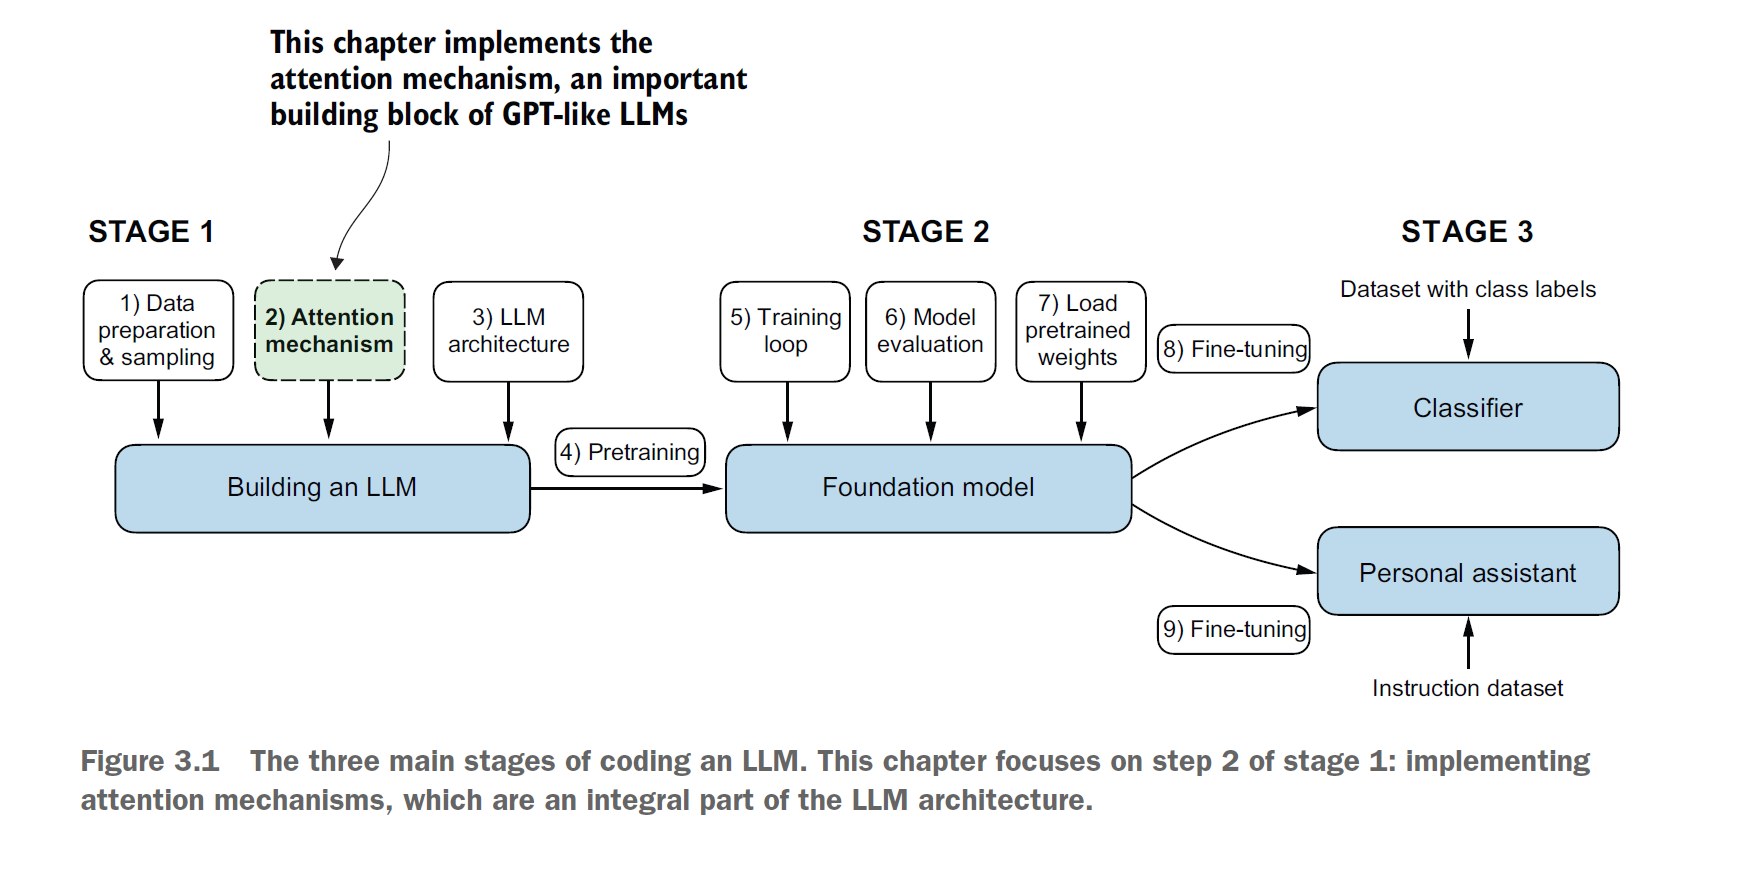

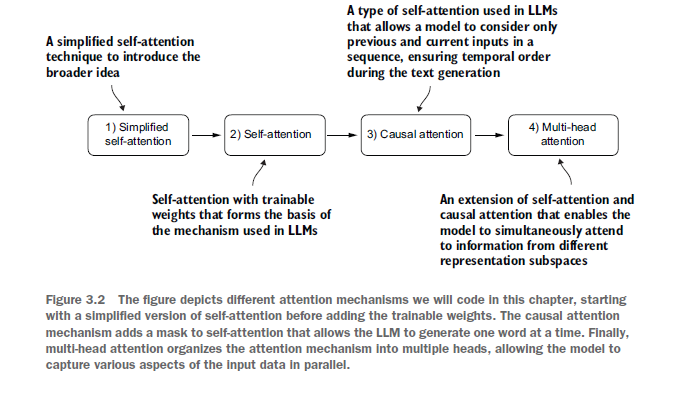

To address the translation problem where a problem of addressing 
difference in grammatical structures from one language to another we use a deep neural network with two submodules, an encoder and decoder. 

The job of the encoder is to first read in and process the entire text and the decoder produces the translated text.

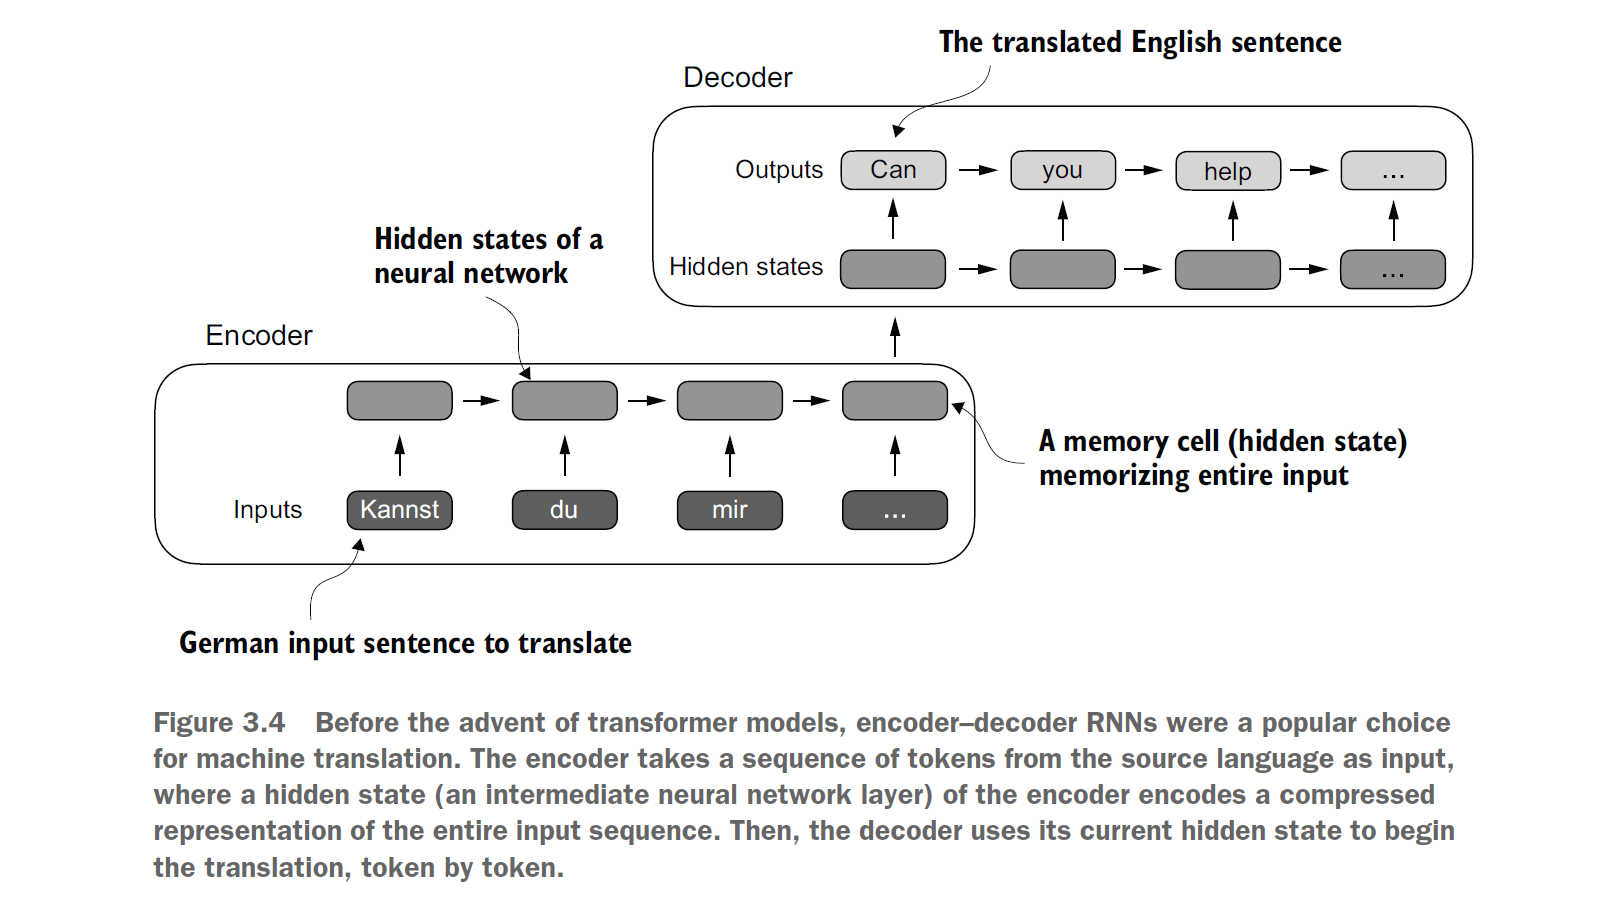

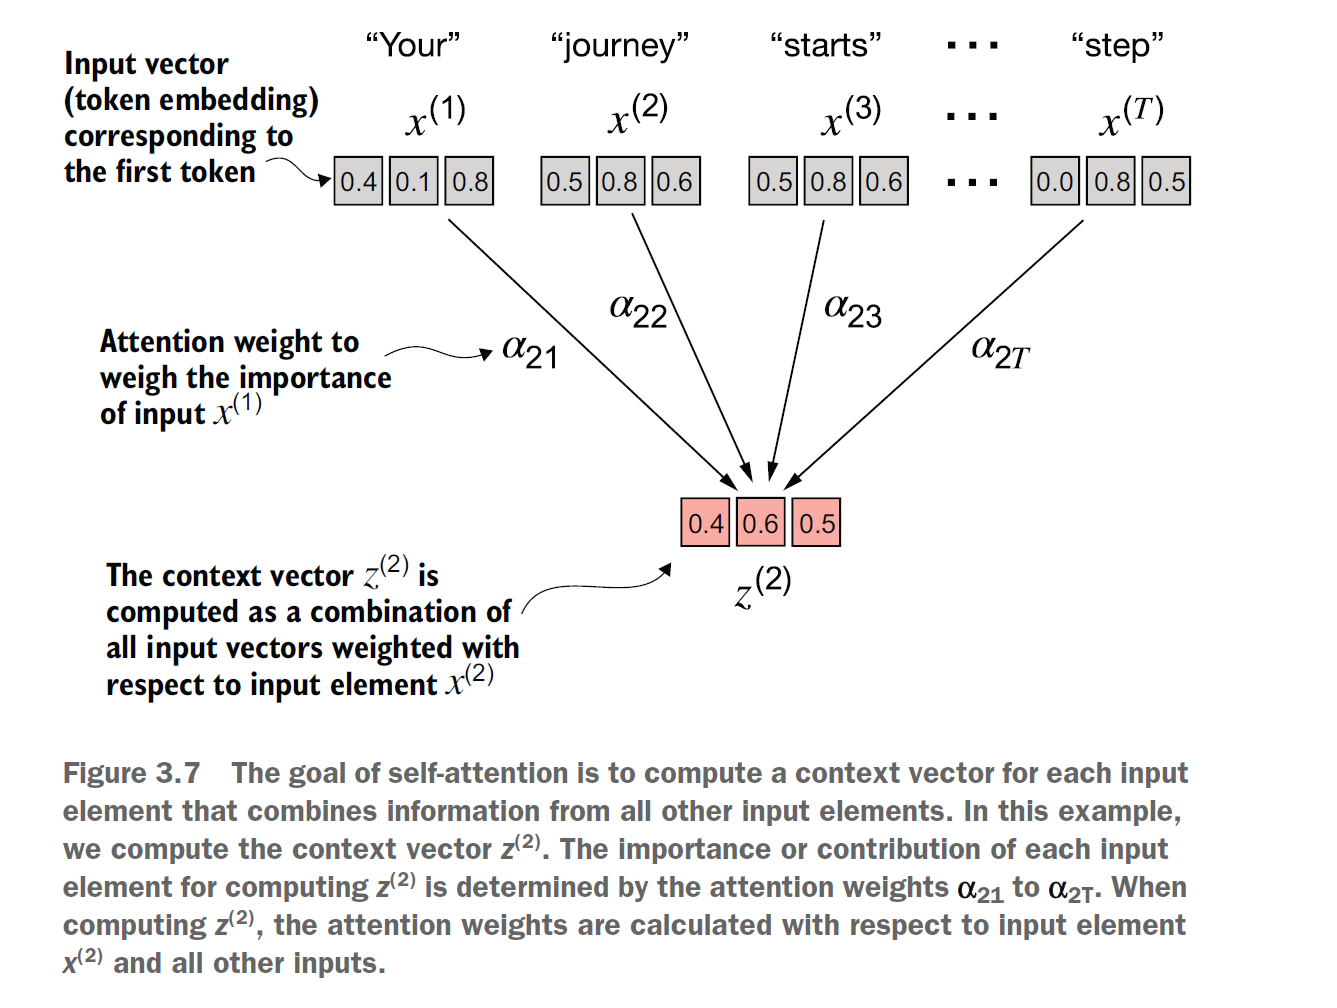

A context vector can be interpreted as an enriched embedding vector.

Context vector plays a crucial role in self-attention. Their purpose is to create enriched representations of each element in an input sequence by incorporating info from all other elements in the sequence. 


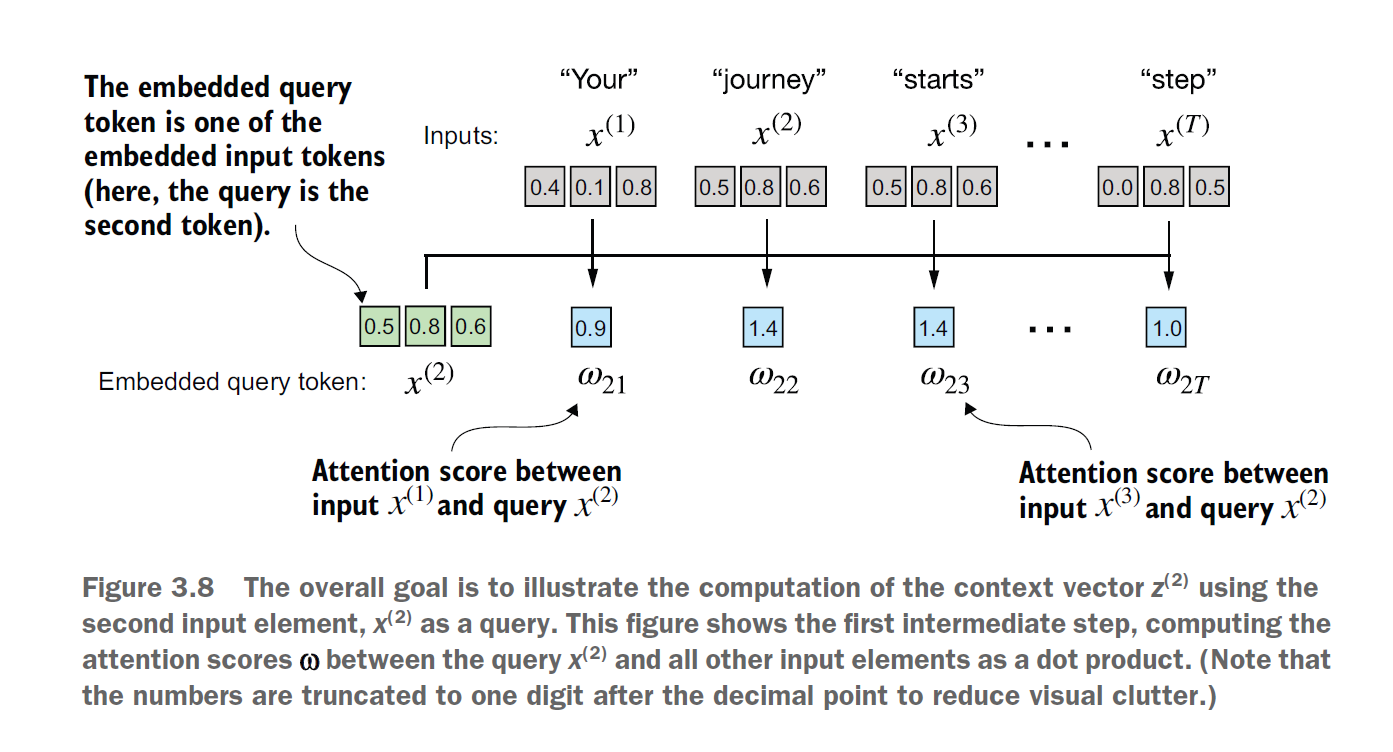

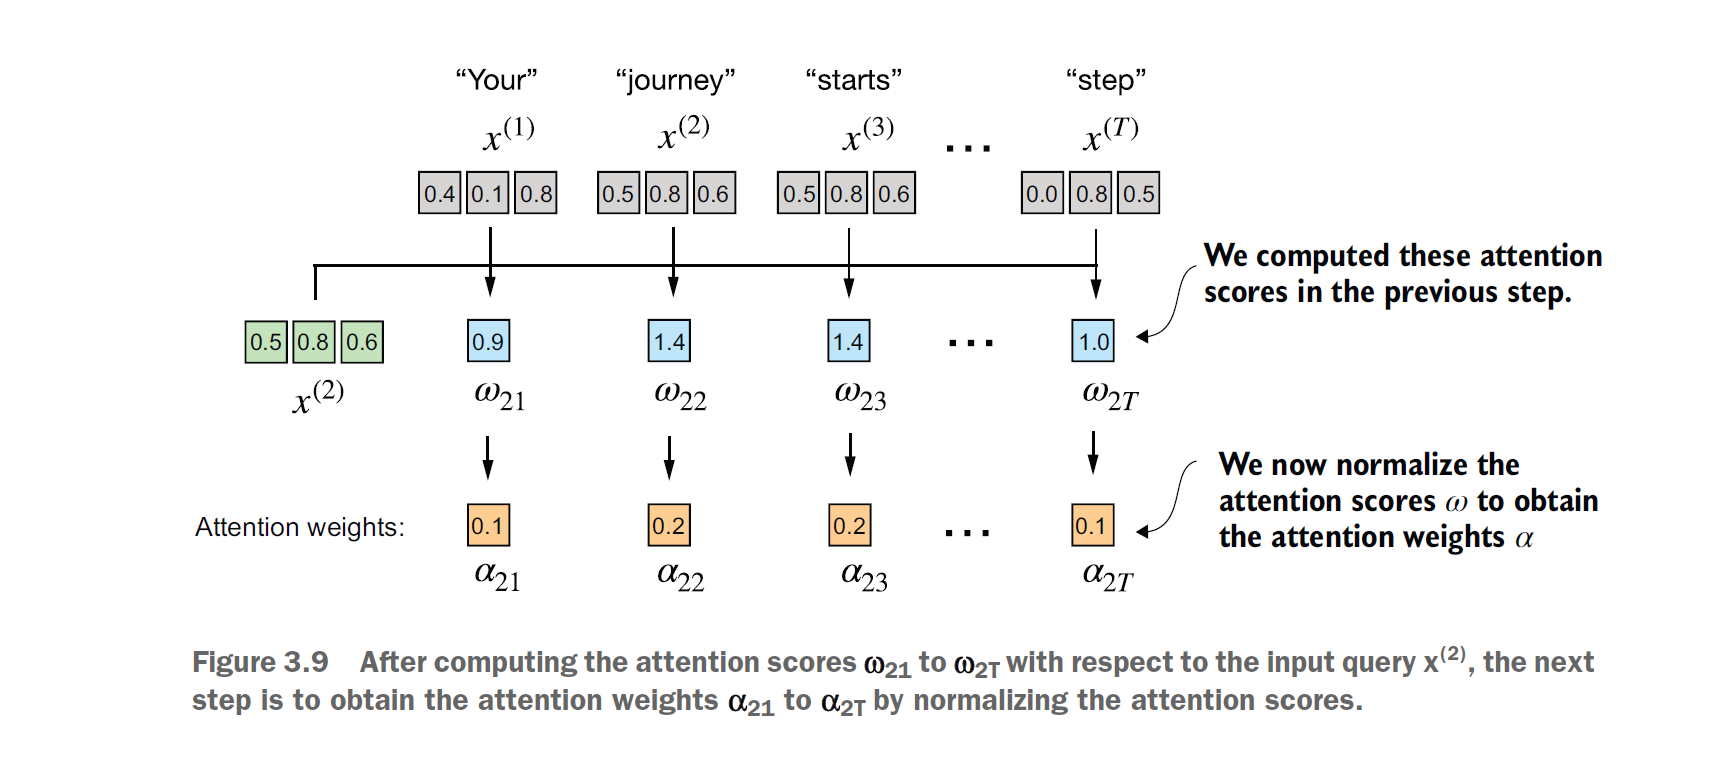

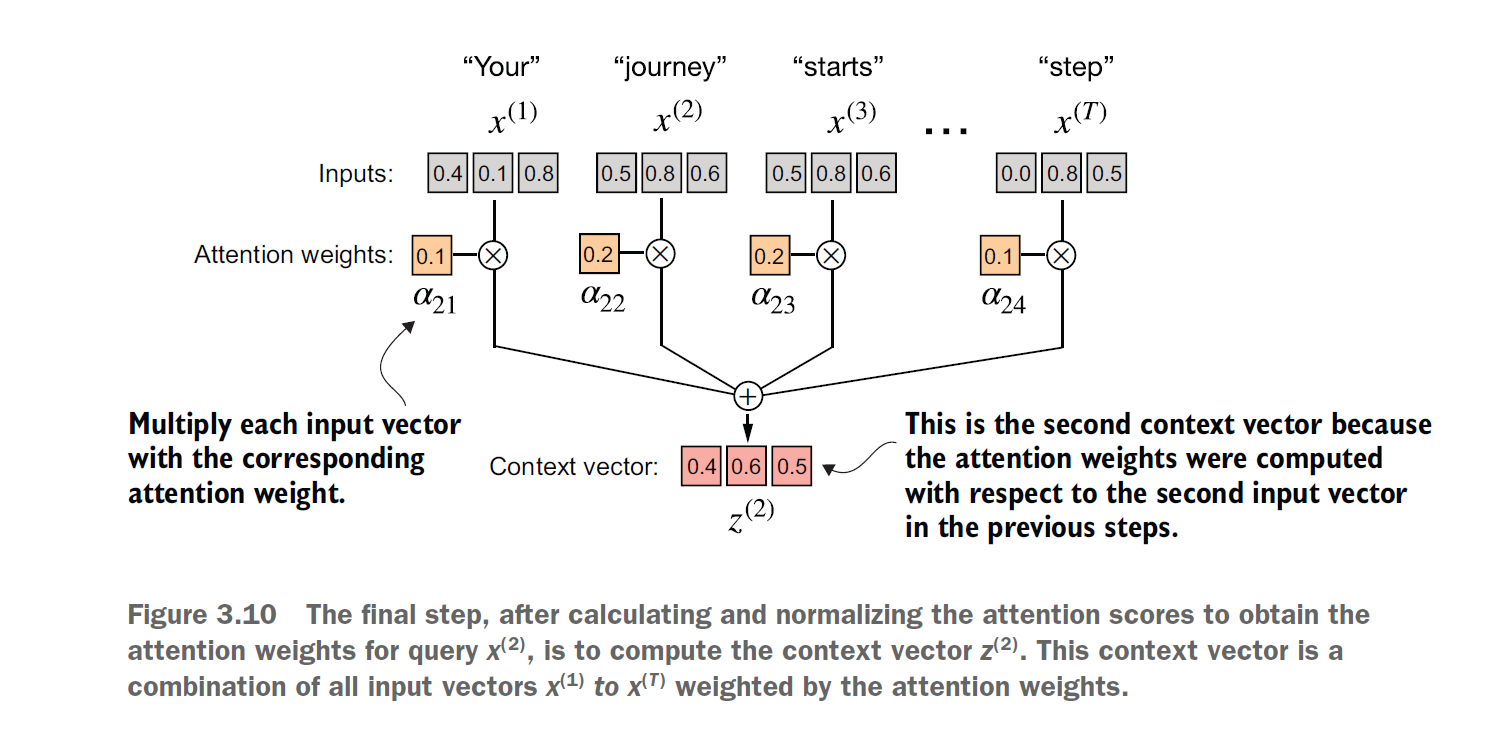

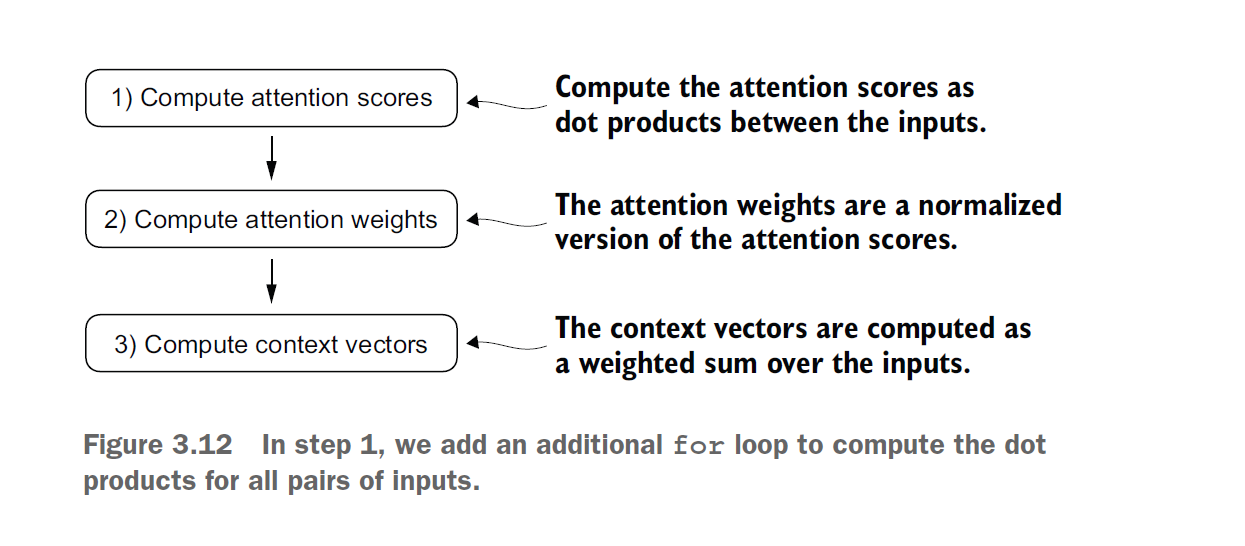

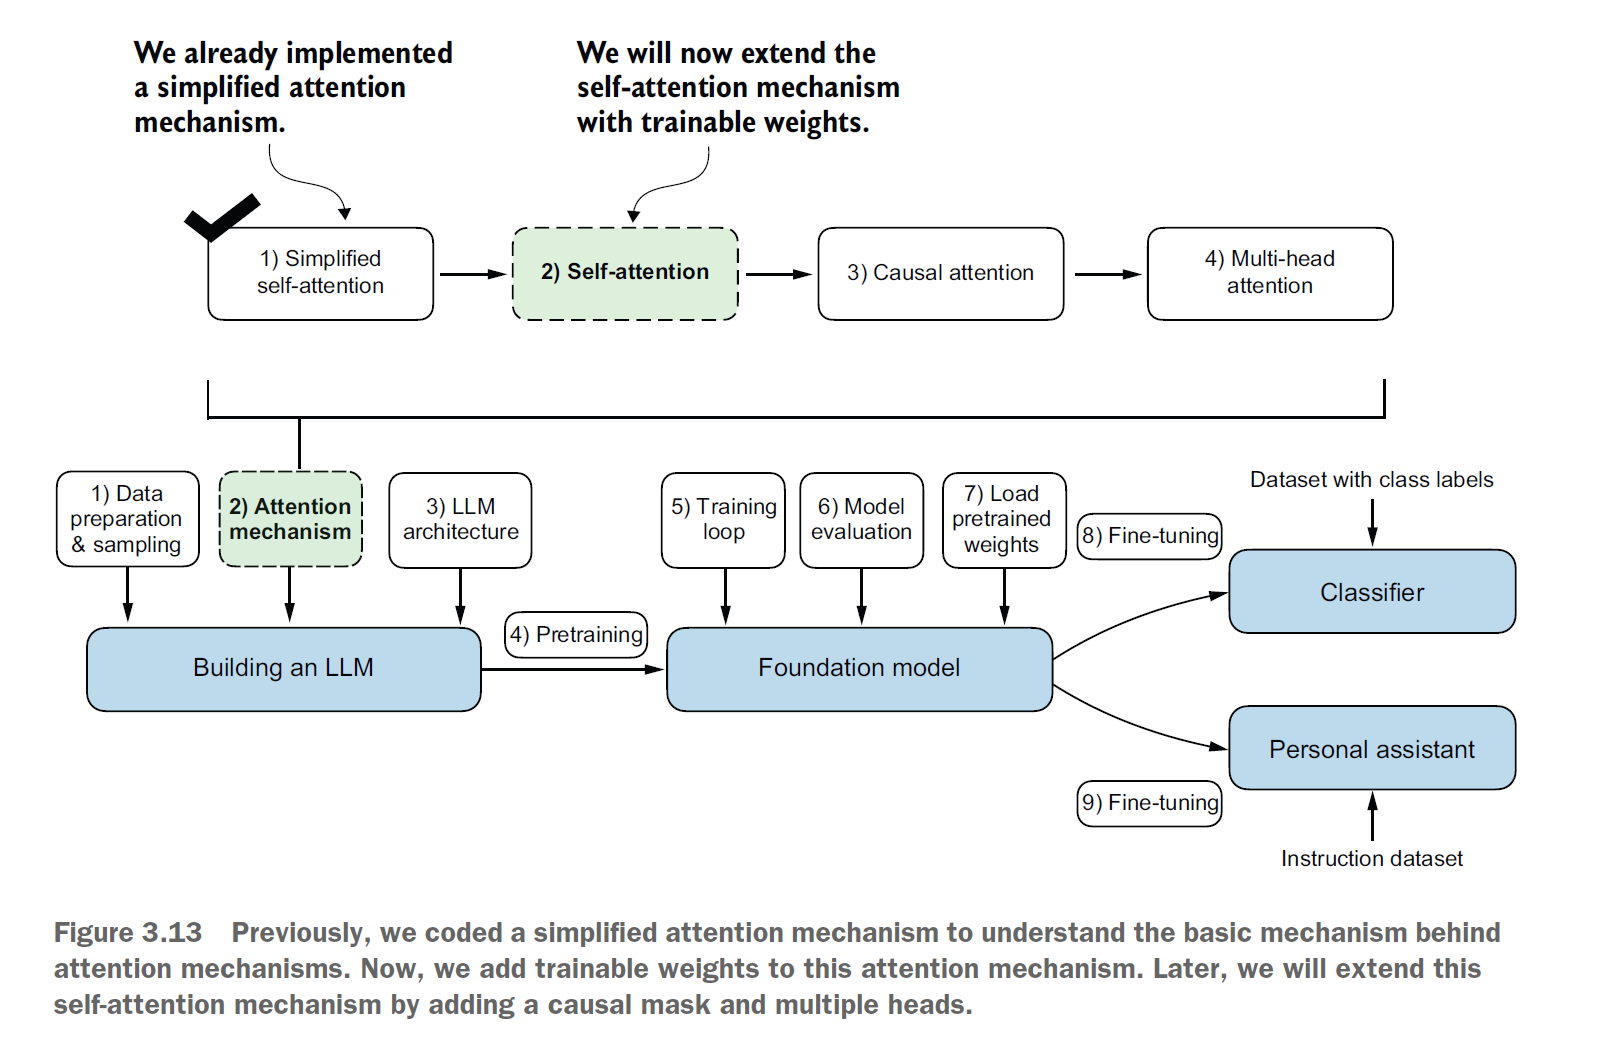

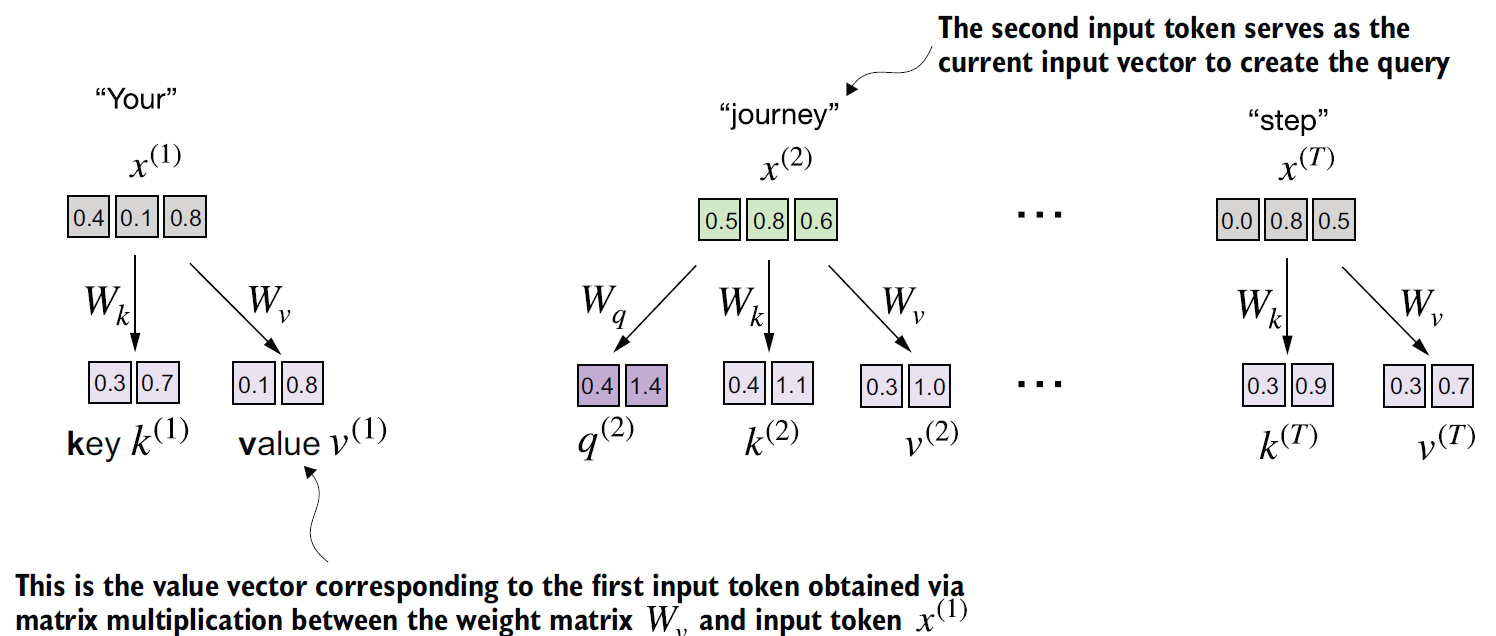

In [16]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

In [17]:
x_2=inputs[1]
d_in=inputs.shape[1]
d_out=2

In [18]:
torch.manual_seed(123)
W_query=torch.nn.Parameter(torch.rand(d_in,d_out),requires_grad=False)
W_key=torch.nn.Parameter(torch.rand(d_in,d_out),requires_grad=False)
W_value=torch.nn.Parameter(torch.rand(d_in,d_out),requires_grad=False)

In [19]:
query_2=x_2 @ W_query
key_2=x_2 @ W_key
value_2=x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])
tensor([0.4306, 1.4551])


In [20]:
keys=inputs @W_key
values=inputs@W_value
print('Keys.shape:',keys.shape)
print('Values.shape:',values.shape)

Keys.shape: torch.Size([6, 2])
Values.shape: torch.Size([6, 2])
Keys.shape: torch.Size([6, 2])
Values.shape: torch.Size([6, 2])


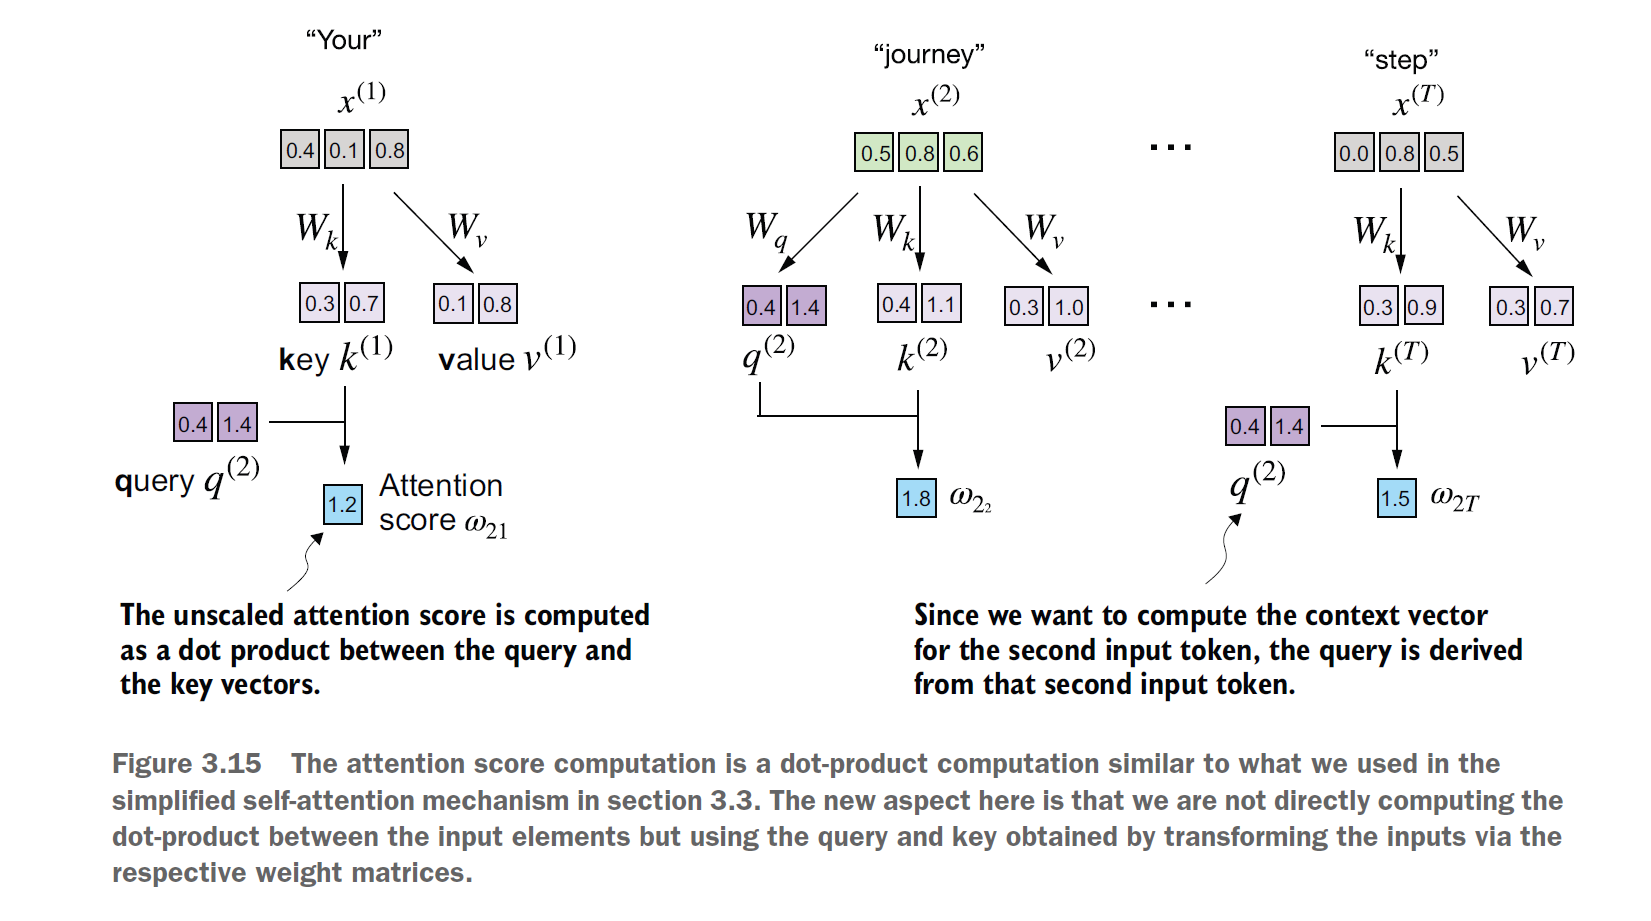

In [21]:
keys_2=keys[1]
attn_score_22=query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)
tensor(1.8524)


In [22]:
attn_scores_2=query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])
tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [23]:
d_k=keys.shape[-1]
attn_weights_2=torch.softmax(attn_scores_2/d_k**0.5,dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1000 for GPT- like LLMs, large dot products can result in very small gradients during backpropogation due to the softmax function applied to them. As dot product increases the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate. 

In [24]:
context_vec_2=attn_weights_2 @values
print(context_vec_2)

tensor([0.3061, 0.8210])
tensor([0.3061, 0.8210])


# Why query, key, and value?

The terms “key,” “query,” and “value” in the context of attention mechanisms are
borrowed from the domain of information retrieval and databases, where similar concepts
are used to store, search, and retrieve information.

A query is analogous to a search query in a database. It represents the current item
(e.g., a word or token in a sentence) the model focuses on or tries to understand.
The query is used to probe the other parts of the input sequence to determine how
much attention to pay to them.

The key is like a database key used for indexing and searching. In the attention mechanism,
each item in the input sequence (e.g., each word in a sentence) has an associated
key. These keys are used to match the query.

The value in this context is similar to the value in a key-value pair in a database. It
represents the actual content or representation of the input items. Once the model
determines which keys (and thus which parts of the input) are most relevant to the
query (the current focus item), it retrieves the corresponding values.

# Implementing a compact self-attention Python class

In [25]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self,d_in,d_out):
        super().__init__()
        self.W_query=nn.Parameter(torch.rand(d_in,d_out))
        self.W_key=nn.Parameter(torch.rand(d_in,d_out))
        self.W_value=nn.Parameter(torch.rand(d_in,d_out))
    
    def forward(self,x):
        keys= x@self.W_key
        queries= x@self.W_query
        values= x@self.W_value
        attn_scores=queries@keys.T
        attn_weights=torch.softmax(
            attn_scores/keys.shape[-1]**0.5,dim=-1)
        context_vec=attn_weights@values
        return context_vec

In [26]:
torch.manual_seed(123)
sa_v1=SelfAttention_v1(d_in,d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)
tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


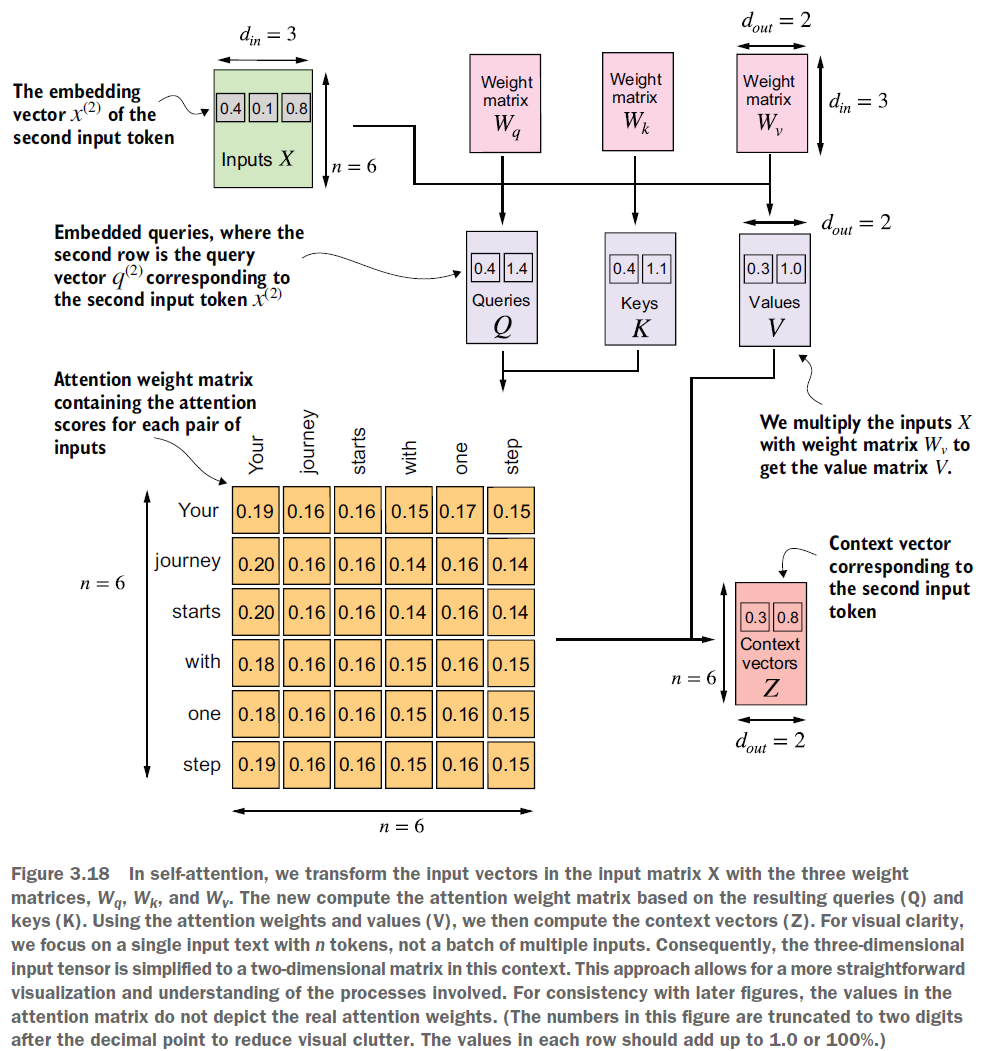

In [27]:
class SelfAttention_v2(nn.Module):
    def __init__(self,d_in,d_out,qkv_bias=False):
        super().__init__()
        self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
    
    def forward(self,x):
        keys=self.W_key(x)
        queries=self.W_query(x)
        values=self.W_value(x)
        attn_scores=queries @keys.T
        attn_weights=torch.softmax(
            attn_scores/keys.shape[-1]**0.5,dim=-1)
        context_vec=attn_weights@values
        return context_vec        

In [28]:
torch.manual_seed(789)
sa_v2=SelfAttention_v2(d_in,d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)
tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


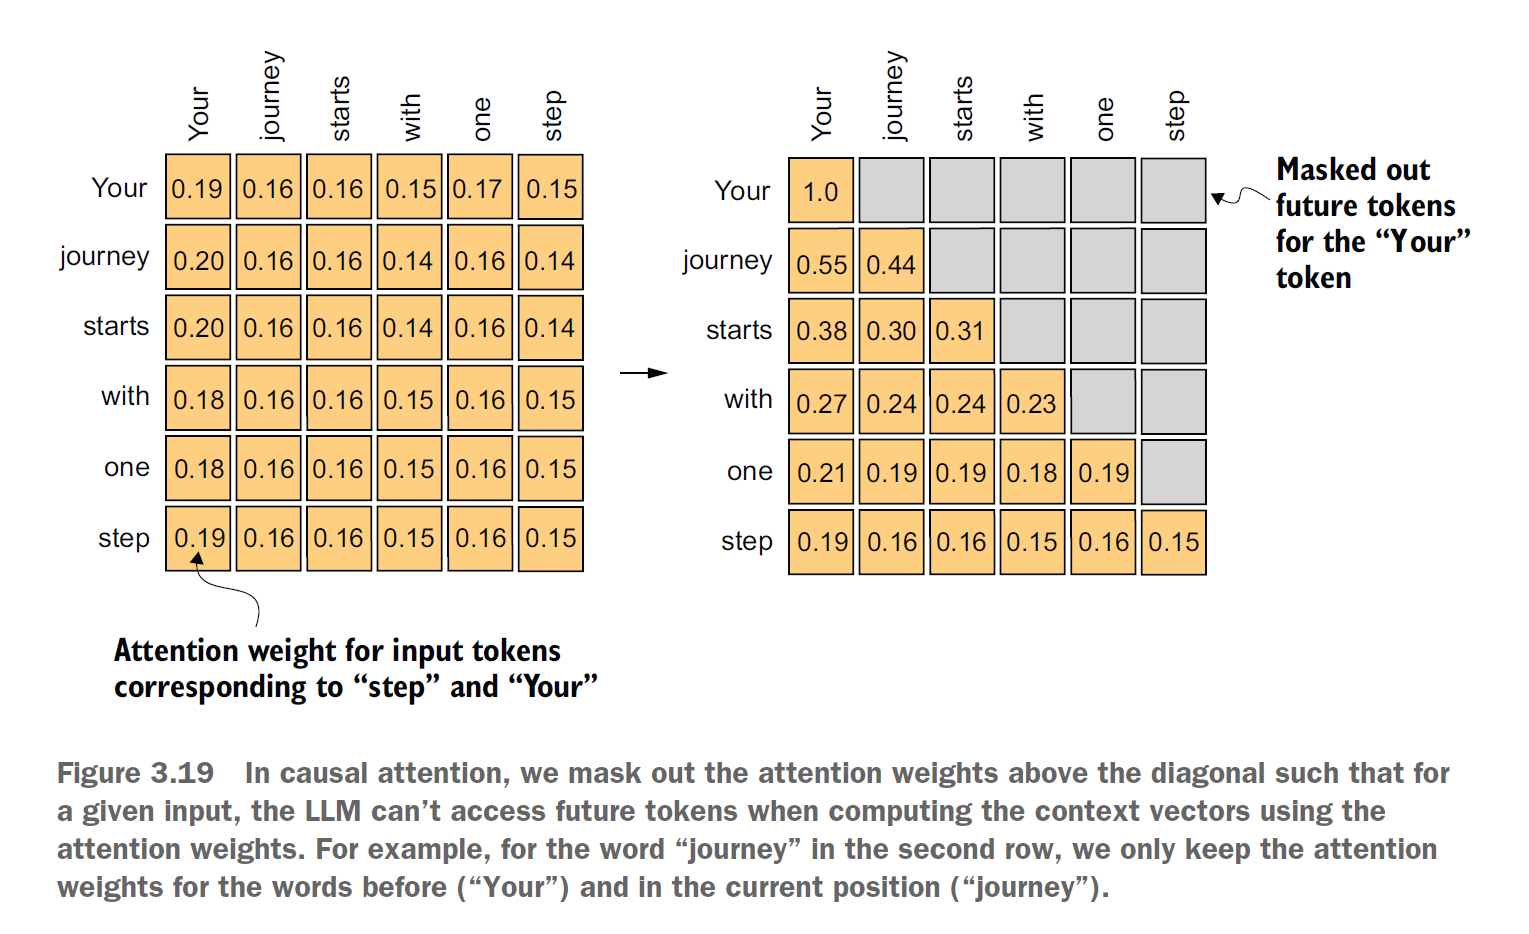

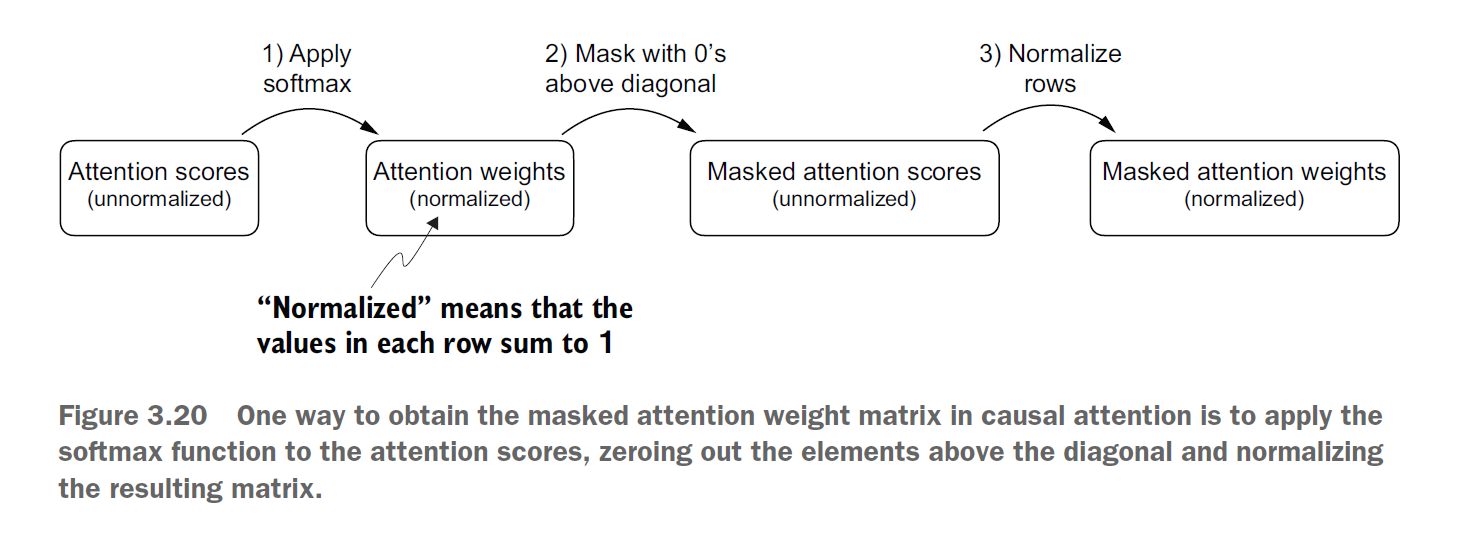

In [29]:
queries=sa_v2.W_query(inputs)
keys=sa_v2.W_key(inputs)
attn_scores=queries @ keys.T
attn_weights=torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [30]:
context_length=attn_scores.shape[0]
mask_simple=torch.tril(torch.ones(context_length,context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])



In [31]:
masked_simple=attn_weights * mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)
tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [32]:
row_sums=masked_simple.sum(dim=-1,keepdim=True)
masked_simple_norm=masked_simple/row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


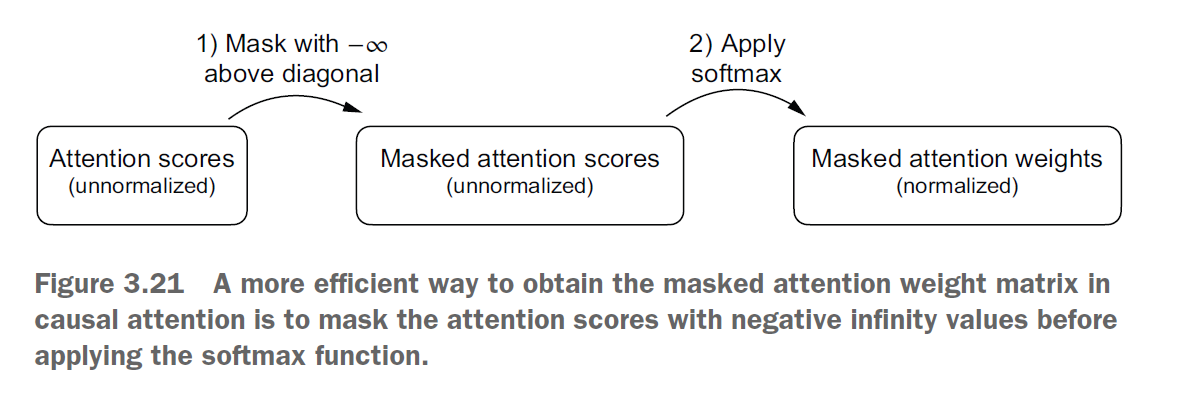

In [33]:
mask=torch.triu(torch.ones(context_length,context_length),diagonal=1)
masked=attn_scores.masked_fill(mask.bool(),-torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)
tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [34]:
attn_weights=torch.softmax(masked/keys.shape[-1]**0.5,dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [35]:
torch.manual_seed(123)
dropout=torch.nn.Dropout(0.5)
example=torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])
tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [36]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


In [37]:
batch=torch.stack((inputs,inputs),dim=0)
print(batch.shape)

torch.Size([2, 6, 3])
torch.Size([2, 6, 3])


In [38]:
class CausalAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,qkv_bias=False):
        super().__init__()
        self.d_out=d_out
        self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length,context_length),diagonal=1)
        )
        
    def forward(self,x):
        b,num_tokens,d_in=x.shape
        keys=self.W_key(x)
        queries=self.W_query(x)
        values=self.W_value(x)
        
        attn_scores=queries @ keys.transpose(1,2)
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens,:num_tokens],-torch.inf)
        attn_weights=torch.softmax(
        attn_scores/keys.shape[-1]**0.5,dim=-1
        )
        attn_weights=self.dropout(attn_weights)
        
        context_vec=attn_weights @ values
        return context_vec

In [39]:
torch.manual_seed(123)
context_length=batch.shape[1]
ca=CausalAttention(d_in,d_out,context_length,0.0)
context_vecs=ca(batch)
print("context_vecs.shape:",context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])
context_vecs.shape: torch.Size([2, 6, 2])


# Stacking multiple single head attention layers

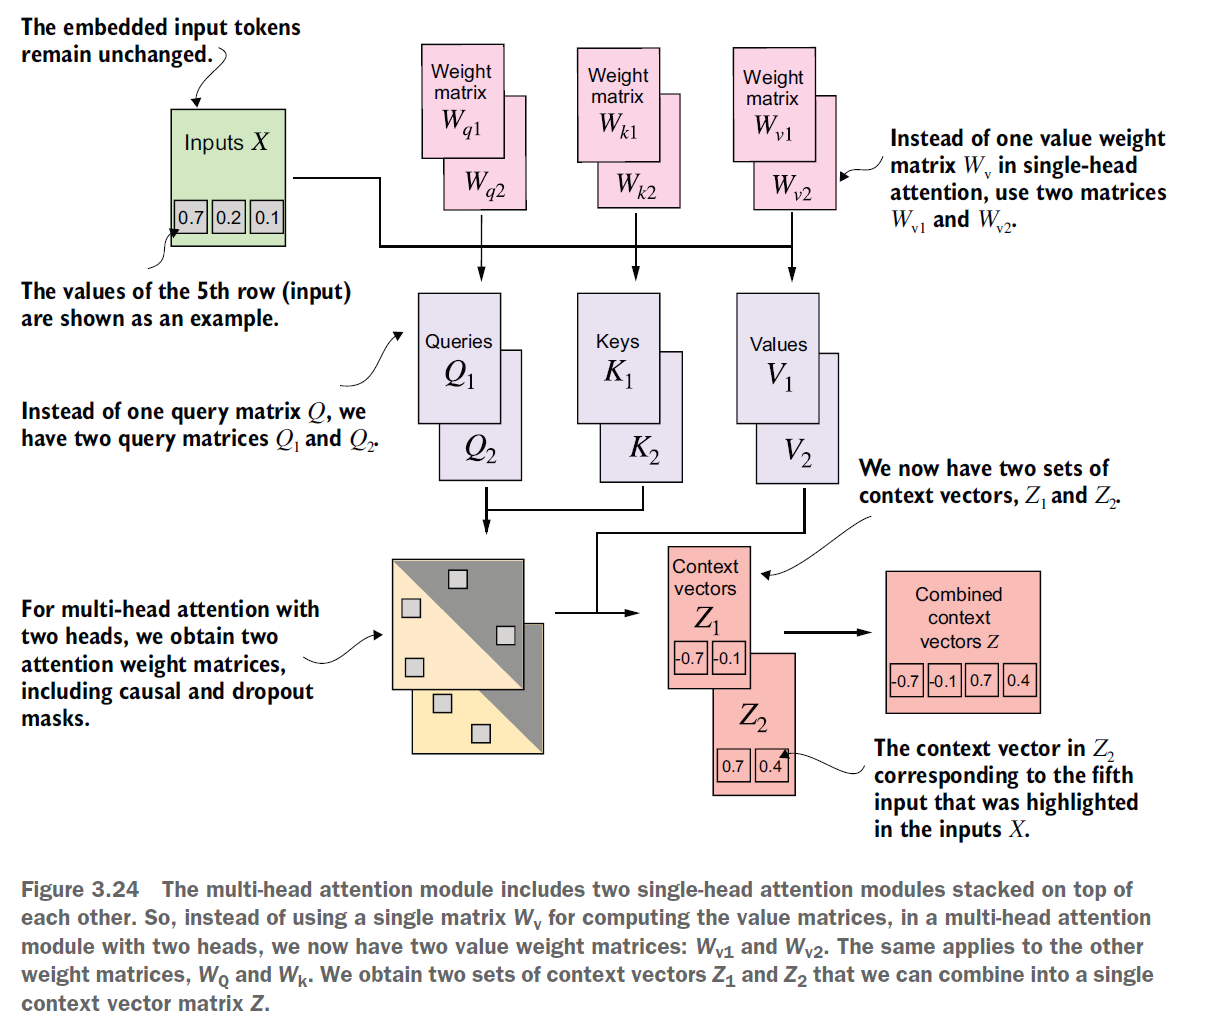

In [40]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        self.heads=nn.ModuleList(
        [CausalAttention(
            d_in,d_out,context_length,dropout,qkv_bias
        )
        for _ in range(num_heads)]
        )
    
    def forward(self,x):
        return torch.cat([head(x) for head in self.heads],dim=-1)

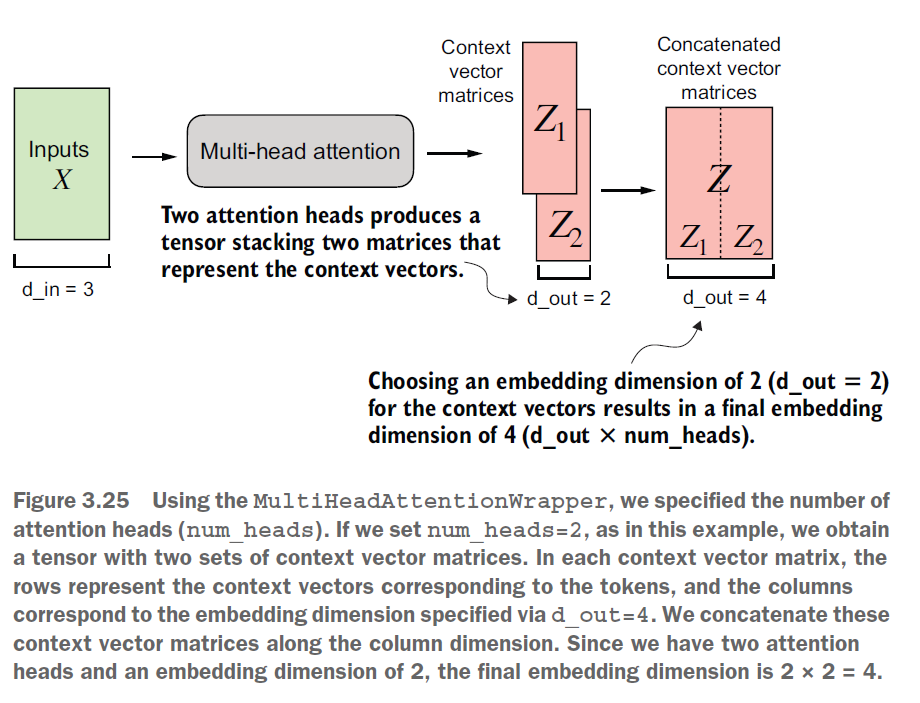

In [41]:
torch.manual_seed(123)
context_length=batch.shape[1] #This is the number of tokens
d_in,d_out=3,2
mha=MultiHeadAttentionWrapper(
    d_in,d_out,context_length,0.0,num_heads=2
)
context_vecs=mha(batch)

In [42]:
print(context_vecs)
print("context_vecs.shape:",context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])
tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891

# Implementing multi-head attention with weight splits

In [43]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads==0),\
            "d_out must be divisible by num_heads"
        self.d_out=d_out
        self.num_heads=num_heads
        self.head_dim=d_out // num_heads
        self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length,context_length),diagonal=1)
        )
        
    def forward(self,x):
        b,num_tokens,d_in=x.shape
        keys=self.W_key(x)
        queries=self.W_query(x)
        values=self.W_value(x)
        keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
        values=values.view(b,num_tokens,self.num_heads,self.head_dim)
        queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
        
        keys=keys.transpose(1,2)
        queries=queries.transpose(1,2)
        values=values.transpose(1,2)
        
        attn_scores=queries@keys.transpose(2,3)
        mask_bool=self.mask.bool()[:num_tokens,:num_tokens]
        
        attn_scores.masked_fill_(mask_bool,-torch.inf)
        attn_weights=torch.softmax(
            attn_scores/keys.shape[-1]**0.5,dim=-1)
        attn_weights=self.dropout(attn_weights)
        context_vec=(attn_weights @ values).transpose(1,2)
        
        context_vec=context_vec.contiguous().view(
            b,num_tokens,self.d_out)
        context_vec=self.out_proj(context_vec)
        return context_vec


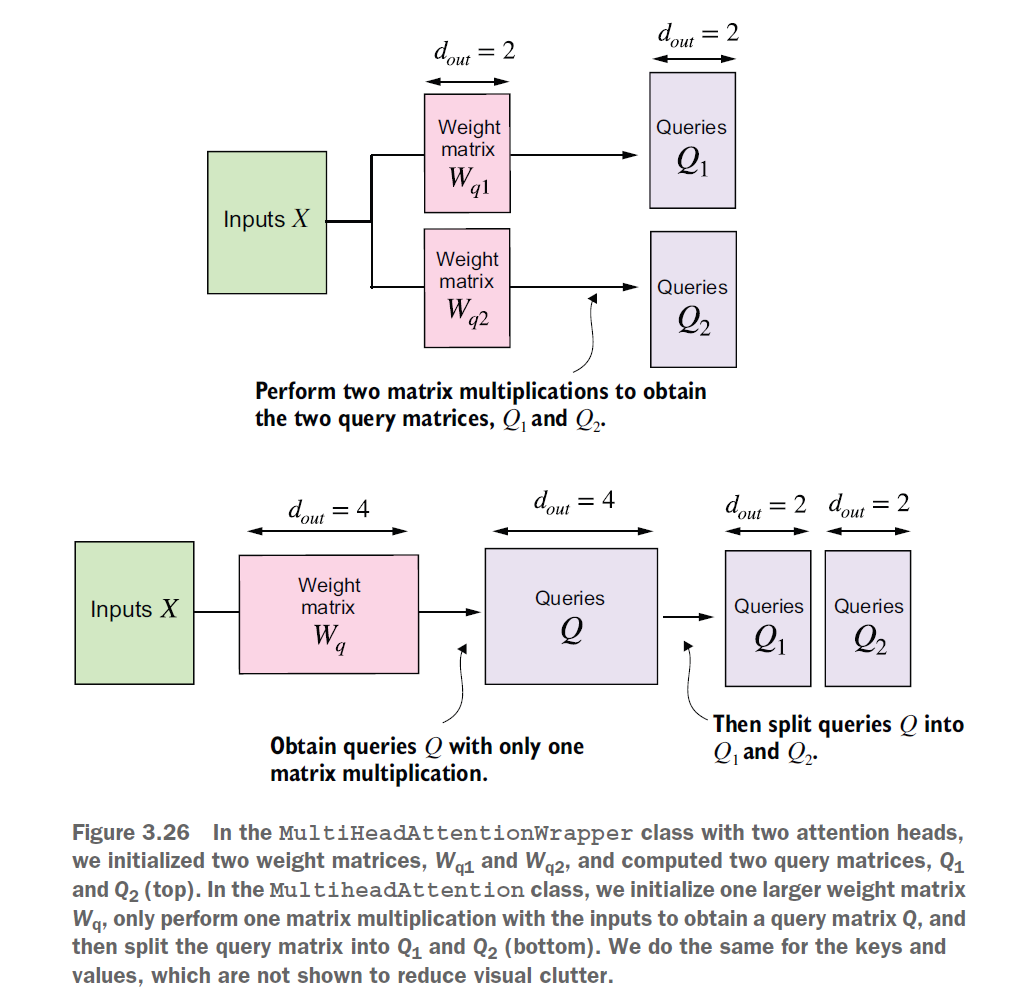

In [44]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
[0.8993, 0.0390, 0.9268, 0.7388],
[0.7179, 0.7058, 0.9156, 0.4340]],
[[0.0772, 0.3565, 0.1479, 0.5331],
[0.4066, 0.2318, 0.4545, 0.9737],
[0.4606, 0.5159, 0.4220, 0.5786]]]])

In [45]:
print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])



In [46]:
torch.manual_seed(123)
batch_size,context_length,d_in=batch.shape
d_out=2
mha=MultiHeadAttention(d_in,d_out,context_length,0.0,num_heads=2)
context_vecs=mha(batch)
print(context_vecs)
print("context_vecs.shape:",context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


# Coding an LLM Architecture

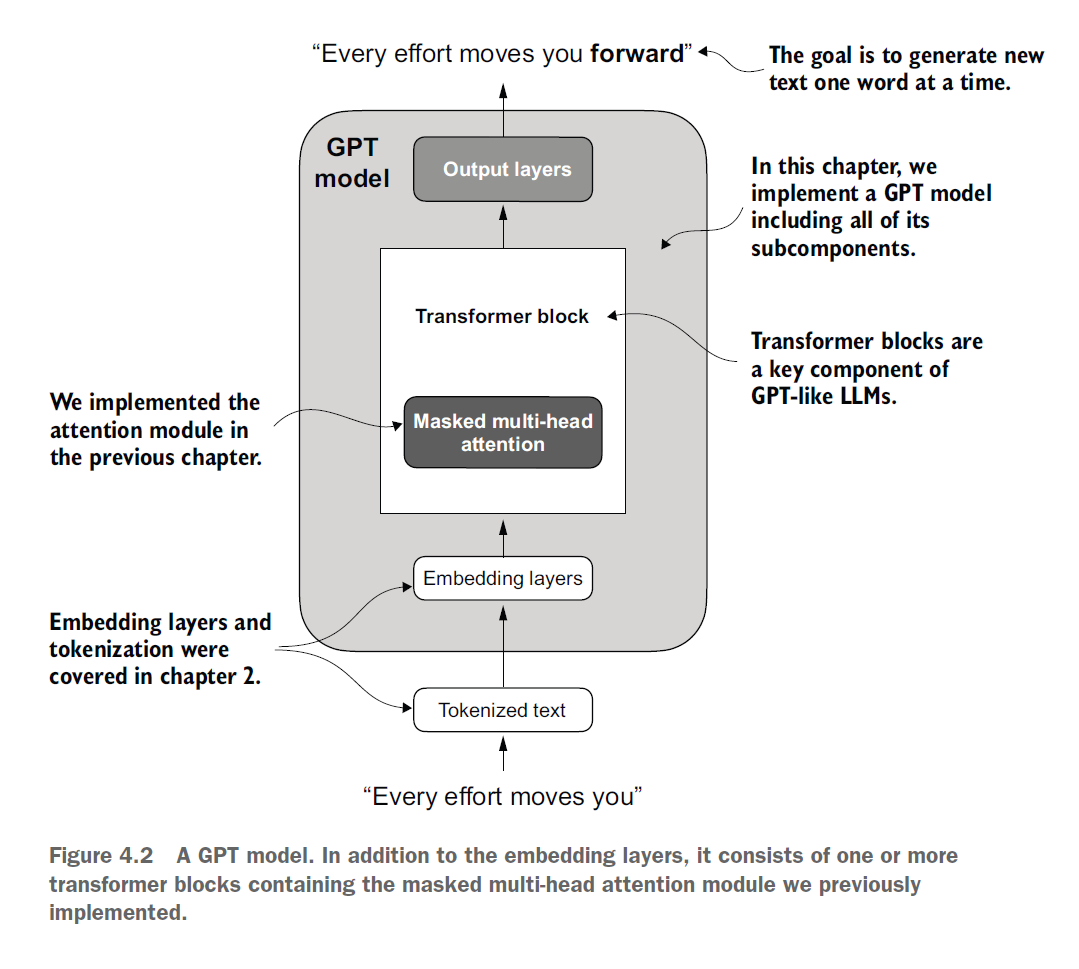

In [47]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,        #Vocabulary size
    "context_length":1024,     #Context Length
    "emb_dim":768,            #Embedding Dimension
    "n_heads":12,             #No of attention heads
    "n_layers":12,            #No of layers
    "drop_rate":0.1,          #Dropout rate
    "qkv_bias":False          #Query-key-value bias
}

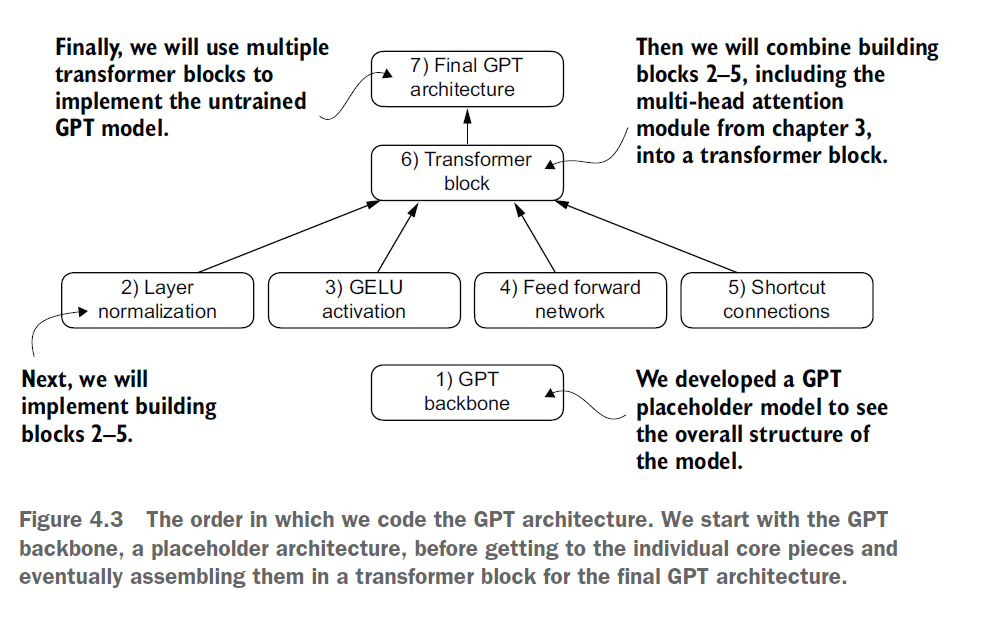

In [48]:
# Placehohlder GPT Model architecture class

import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
        self.pos_emb=nn.Embedding(cfg['context_length'],cfg['emb_dim'])
        self.drop_emb=nn.Dropout(cfg['drop_rate'])
        self.trf_blocks=nn.Sequential(                             #Uses a placeholder for TransformerBlock
            *[DummyTransformerBlock(cfg)
                 for _ in range(cfg['n_layers'])])
        self.final_norm=DummyLayerNorm(cfg['emb_dim'])
        self.out_head=nn.Linear(                                   #uses a placeholder for LayerNorm
            cfg['emb_dim'],cfg['vocab_size'],bias=False
        )
        
    def forward(self,in_idx):
        batch_size,seq_len=in_idx.shape
        tok_embeds=self.tok_emb(in_idx)
        pos_embeds=self.pos_emb(
            torch.arange(seq_len,device=in_idx.device)
        )
        x=tok_embeds + pos_embeds
        x=self.drop_emb(x)
        x=self.trf_blocks(x)
        x=self.final_norm(x)
        logits= self.out_head(x)
        return logits

In [49]:
class DummyTransformerBlock(nn.Module):   # A simple placeholder class that will be replaced by a real TransformerBlock later
    def __init__(self,cfg):
        super().__init__()
        
    def forward(self,x):
        return x

In [50]:
class DummyLayerNorm(nn.Module):         # A simple placeholder classs that will be replaced by a real LayerNorm later
    def __init__(self,normalized_shape,eps=1e-5):
        super().__init__()
        
    def forward(self,x):
        return x

In [51]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')
batch=[]
txt1='Every effort moves you'
txt2='Every day holds a'

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch=torch.stack(batch,dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [52]:
torch.manual_seed(123)
model=DummyGPTModel(GPT_CONFIG_124M)
logits=model(batch)
print('Output shape:',logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.05

# Normalizing activations with layer normalization

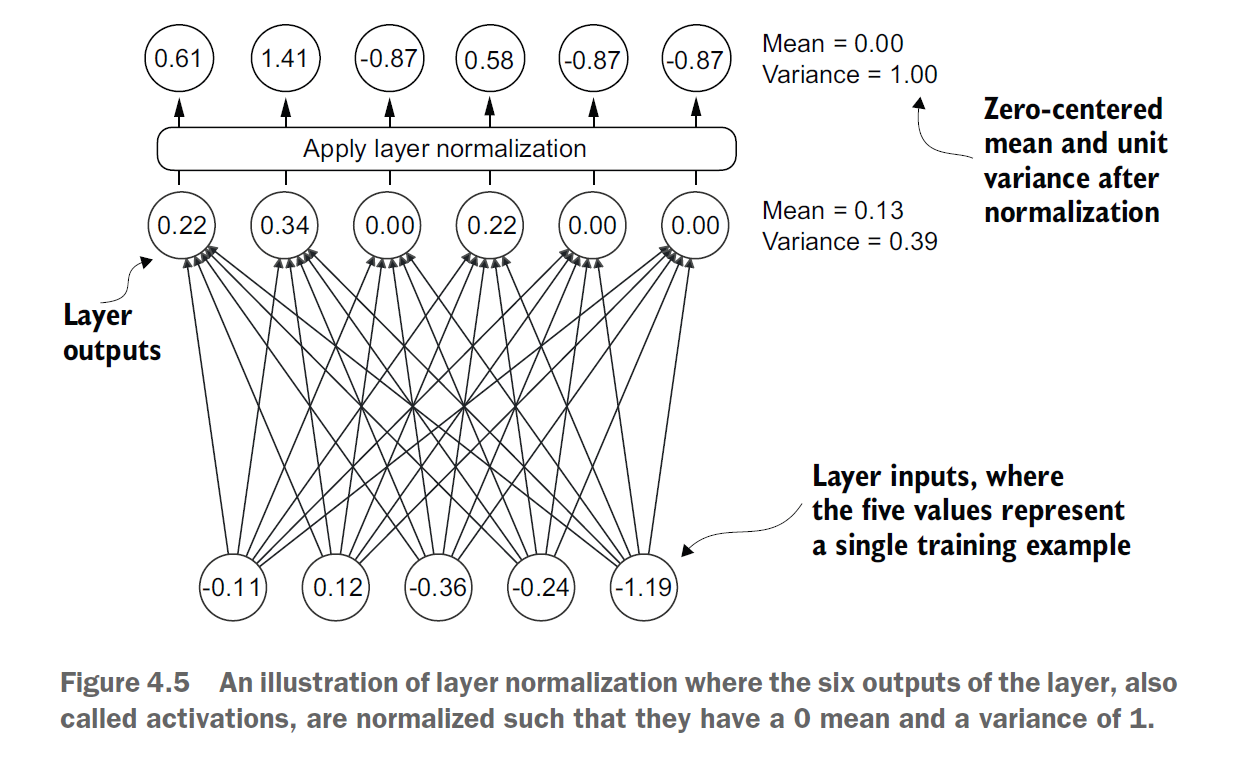

In [53]:
torch.manual_seed(123)
batch_example=torch.randn(2,5)
layer=nn.Sequential(nn.Linear(5,6),nn.ReLU())
out=layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [54]:
mean=out.mean(dim=-1,keepdim=True)
var=out.var(dim=-1,keepdim=True)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [55]:
out_norm=(out-mean)/torch.sqrt(var)
mean=out_norm.mean(dim=-1,keepdim=True)
var=out_norm.var(dim=-1,keepdim=True)
print('Normalized layer outputs:\n',out_norm)
print('Mean:\n',mean)
print('Variance:\n',var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [56]:
#A layer normalization class

class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        var=x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x=(x-mean) / torch.sqrt(var+self.eps)
        return self.scale*norm_x + self.shift

In [57]:
ln=LayerNorm(emb_dim=5)
out_ln=ln(batch_example)
mean=out_ln.mean(dim=-1,keepdim=True)
var=out_ln.var(dim=-1,unbiased=False,keepdim=True)
print('Mean:\n',mean)
print('Variance:\n',var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


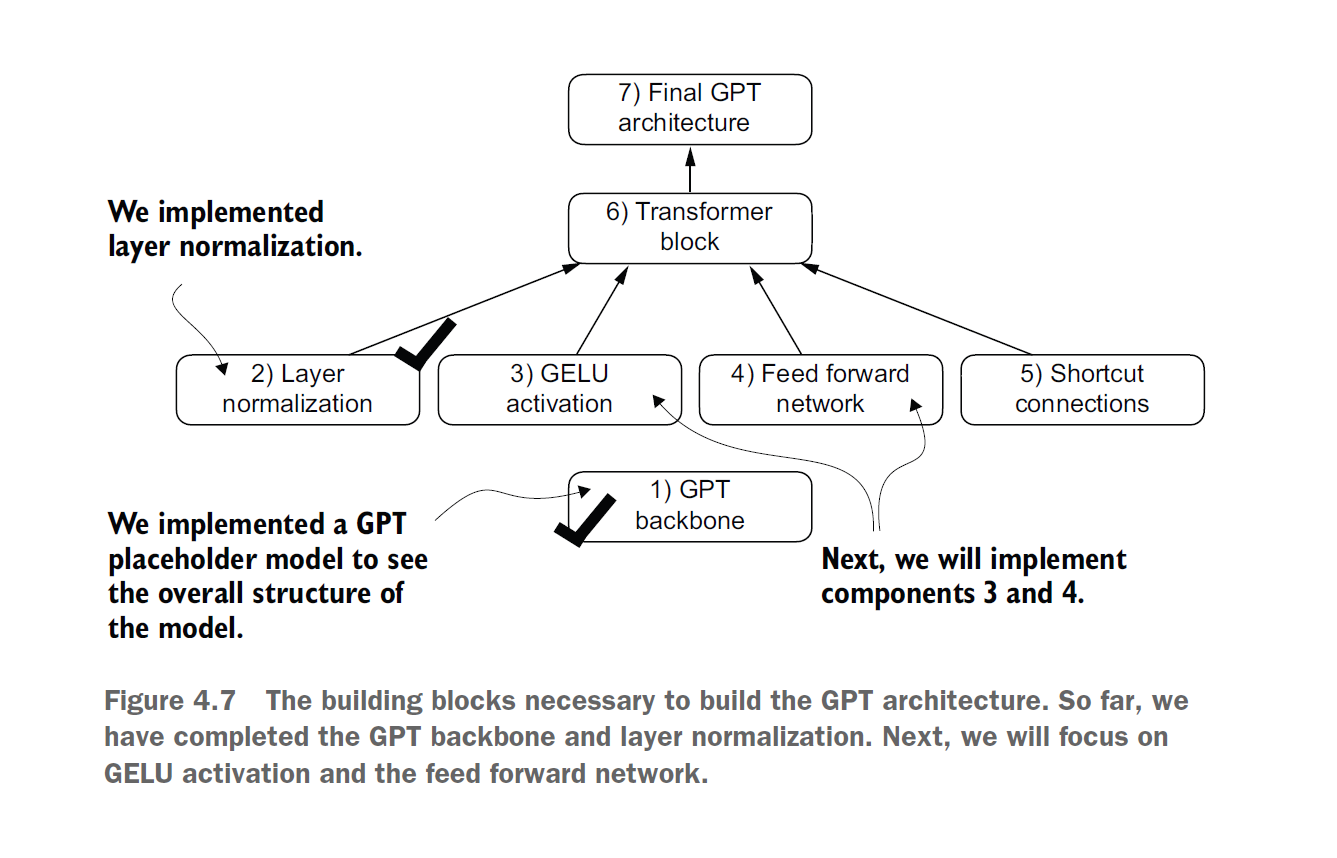

In [58]:
# Implementing a feed forward network with GELU activations

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        return 0.5 * x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi))* ( x + 0.044715*torch.pow(x,3))
        ))

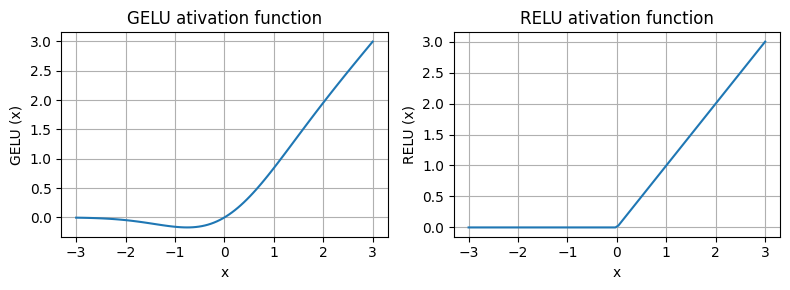

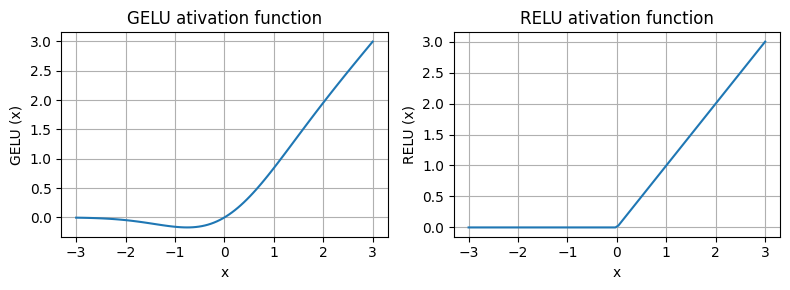

In [59]:
import matplotlib.pyplot as plt
gelu,relu=GELU(),nn.ReLU()

x= torch.linspace(-3,3,100)
y_gelu,y_relu=gelu(x),relu(x)
plt.figure(figsize=(8,3))
for i,(y,label) in enumerate (zip([y_gelu,y_relu],["GELU","RELU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} ativation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg['emb_dim'],cfg['emb_dim']),
        )
        
    def forward (self,x):
        return self.layers(x)

In [61]:
ffn=FeedForward(GPT_CONFIG_124M)
x=torch.rand(2,3,768)
out=ffn(x)
print(out.shape)

torch.Size([2, 3, 768])
torch.Size([2, 3, 768])


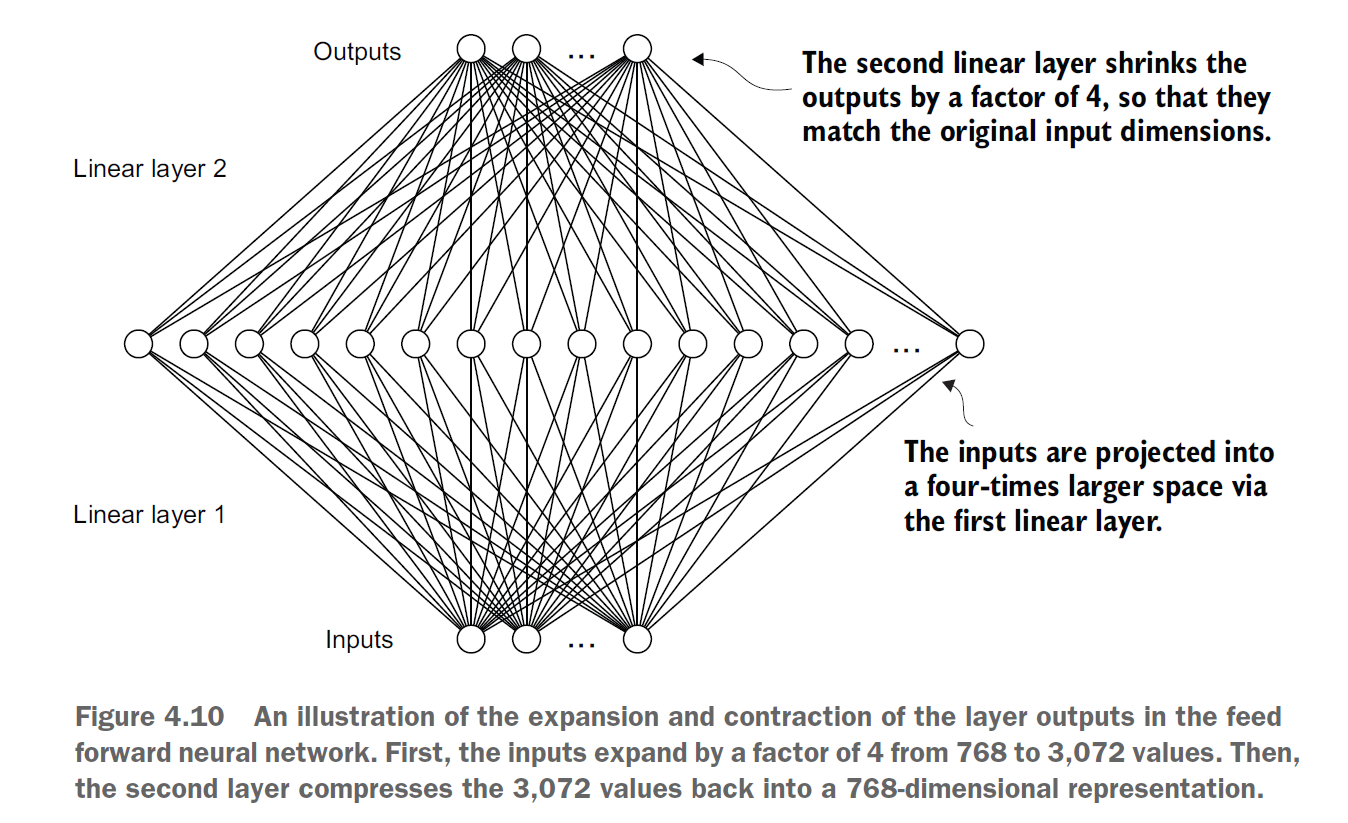

In [62]:
# Adding shortcut connections

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers=nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                            GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                            GELU())
        ])
        
    def forward(self,x):
        for layer in self.layers:
            layer_output=layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x=x+layer_output
            else:
                x=layer_output
            return x

In [63]:
layer_sizes = [3,3,3,3,3,1]
sample_input=torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut=ExampleDeepNeuralNetwork(
    layer_sizes,use_shortcut=False
)

In [64]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            if param.grad is not None:  # Ensure grad is not None before using .abs()
                print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
            else:
                print(f"{name} has no gradient (NoneType). Ensure loss.backward() is called.")

In [65]:
print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.03372582048177719
layers.1.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.2.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.3.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.4.0.weight has no gradient (NoneType). Ensure loss.backward() is called.


D:\Docs\LLM\cuda\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


layers.0.0.weight has gradient mean of 0.03372582048177719
layers.1.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.2.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.3.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.4.0.weight has no gradient (NoneType). Ensure loss.backward() is called.


D:\Docs\LLM\cuda\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [66]:
torch.manual_seed(123)
model_with_shortcut=ExampleDeepNeuralNetwork(
    layer_sizes,use_shortcut=True
)
print_gradients(model_with_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.21964700520038605
layers.1.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.2.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.3.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.4.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.0.0.weight has gradient mean of 0.21964700520038605
layers.1.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.2.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.3.0.weight has no gradient (NoneType). Ensure loss.backward() is called.
layers.4.0.weight has no gradient (NoneType). Ensure loss.backward() is called.


# Connecting attention and linear layers in a transformer block

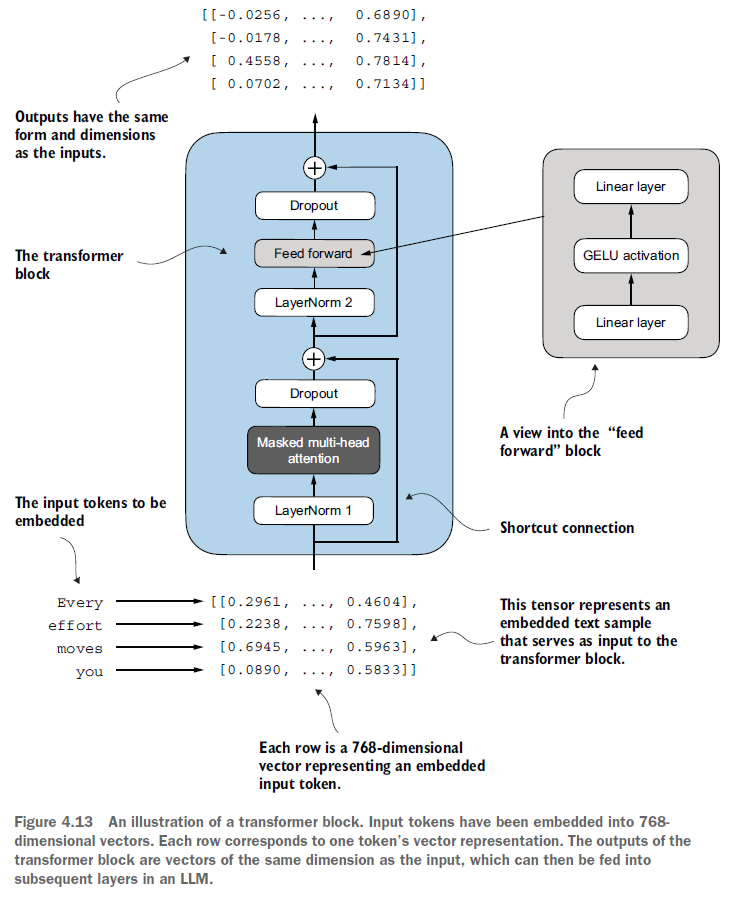

In [67]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias'])
        self.ff=FeedForward(cfg)
        self.norm1=LayerNorm(cfg['emb_dim'])
        self.norm2=LayerNorm(cfg['emb_dim'])
        self.drop_shortcut=nn.Dropout(cfg['drop_rate'])
        
    def forward(self,x):
        
        shortcut=x
        x=self.norm1(x)
        x=self.att(x)
        x=self.drop_shortcut(x)
        x=x+shortcut
        
        shorcut= x
        x=self.norm2(x)
        x=self.ff(x)
        x=self.drop_shortcut(x)
        x=x+shortcut
        return x

In [68]:
torch.manual_seed(123)
x=torch.rand(2,4,768)
block=TransformerBlock(GPT_CONFIG_124M)
output=block(x)

print('Input Shape:',x.shape)
print('Output Shape:',output.shape)

Input Shape:Input Shape: torch.Size([2, 4, 768])
Output Shape: torch.Size([2, 4, 768])
 torch.Size([2, 4, 768])
Output Shape: torch.Size([2, 4, 768])


In [69]:
# Coding the GPT Model

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
        self.pos_emb=nn.Embedding(cfg['context_length'],cfg['emb_dim'])
        self.drop_emb=nn.Dropout(cfg['drop_rate'])
        
        self.trf_blocks=nn.Sequential(
            *[TransformerBlock(cfg) for _ in range (cfg['n_layers'])])
        
        self.final_norm=LayerNorm(cfg['emb_dim'])
        self.out_head=nn.Linear(
            cfg['emb_dim'],cfg['vocab_size'],bias=False
        )
        
    def forward(self,in_idx):
        batch_size,seq_len=in_idx.shape
        tok_embeds=self.tok_emb(in_idx)
        
        pos_embeds=self.pos_emb(
            torch.arange(seq_len,device=in_idx.device)
        )
        x=tok_embeds+pos_embeds
        x=self.drop_emb(x)
        x=self.trf_blocks(x)
        x=self.final_norm(x)
        logits=self.out_head(x)
        return logits

In [70]:
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)

out=model(batch)
print('Input batch:\n',batch)
print('\nOutput shape:',out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-4.4873e-01, -1.4403e-02, -2.1101e-01,  ..., -1.2148e-01,
          -4.7670e-01, -8.0218e-02],
         [ 5.6700e-01, -6.1946e-01, -6.9026e-01,  ..., -6.4790e-01,
          -3.7354e-01, -6.5172e-02],
         [ 7.0698e-01,  2.9486e-01, -3.3565e-01,  ...,  1.1825e-01,
          -7.7123e-01, -2.9724e-02],
         [-8.0202e-01,  5.0398e-01, -3.5931e-01,  ...,  1.0951e+00,
           1.9778e-01, -3.3406e-01]],

        [[-9.6134e-04, -1.3215e-01, -4.5292e-02,  ..., -2.8721e-01,
          -2.1242e-01, -1.3417e-01],
         [ 2.1804e-01, -5.0582e-03,  2.1164e-01,  ...,  8.5650e-01,
          -3.1484e-01,  3.5217e-01],
         [ 7.2345e-01,  6.6724e-01, -2.4196e-01,  ...,  4.4530e-01,
           1.0173e-01, -1.5907e-01],
         [-2.6010e-01,  1.0558e-01,  2.4214e-01,  ...,  1.1381e+00,
          -5.3183e-01,  1.3849e-02]]], grad_fn=<UnsafeViewBackward0>)
I

In [71]:
#Using numel() method, short for 'num of elements' we can collect the total no of parameters in the model's parameter tensors

total_params=sum(p.numel() for p in model.parameters())
print(f'Total number of parameters : {total_params:,}')

Total number of parameters : 163,009,536
Total number of parameters : 163,009,536


In [72]:
print('Token embedding layer shape:', model.tok_emb.weight.shape)
print('Output layer shape:',model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [73]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160
Number of trainable parameters considering weight tying: 124,412,160


In [74]:
total_size_bytes=total_params * 4
total_size_mb=total_size_bytes/(1024*1024)
print(f'Total size of the model : {total_size_mb:2f} MB')

Total size of the model : 621.832031 MB
Total size of the model : 621.832031 MB


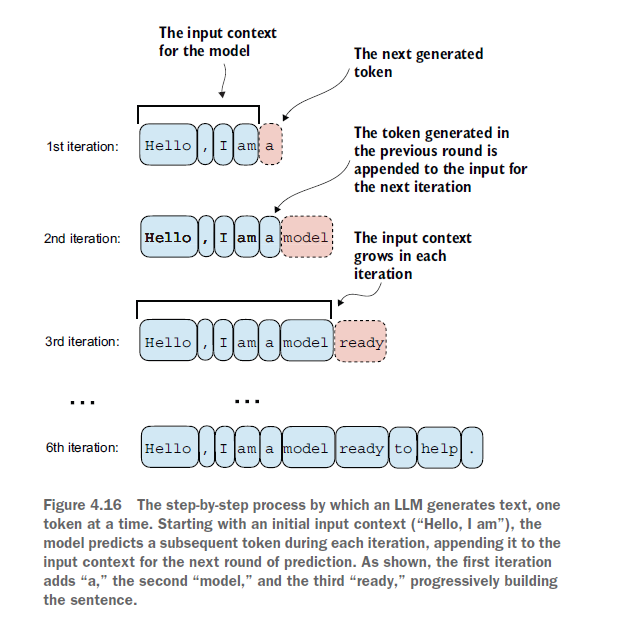

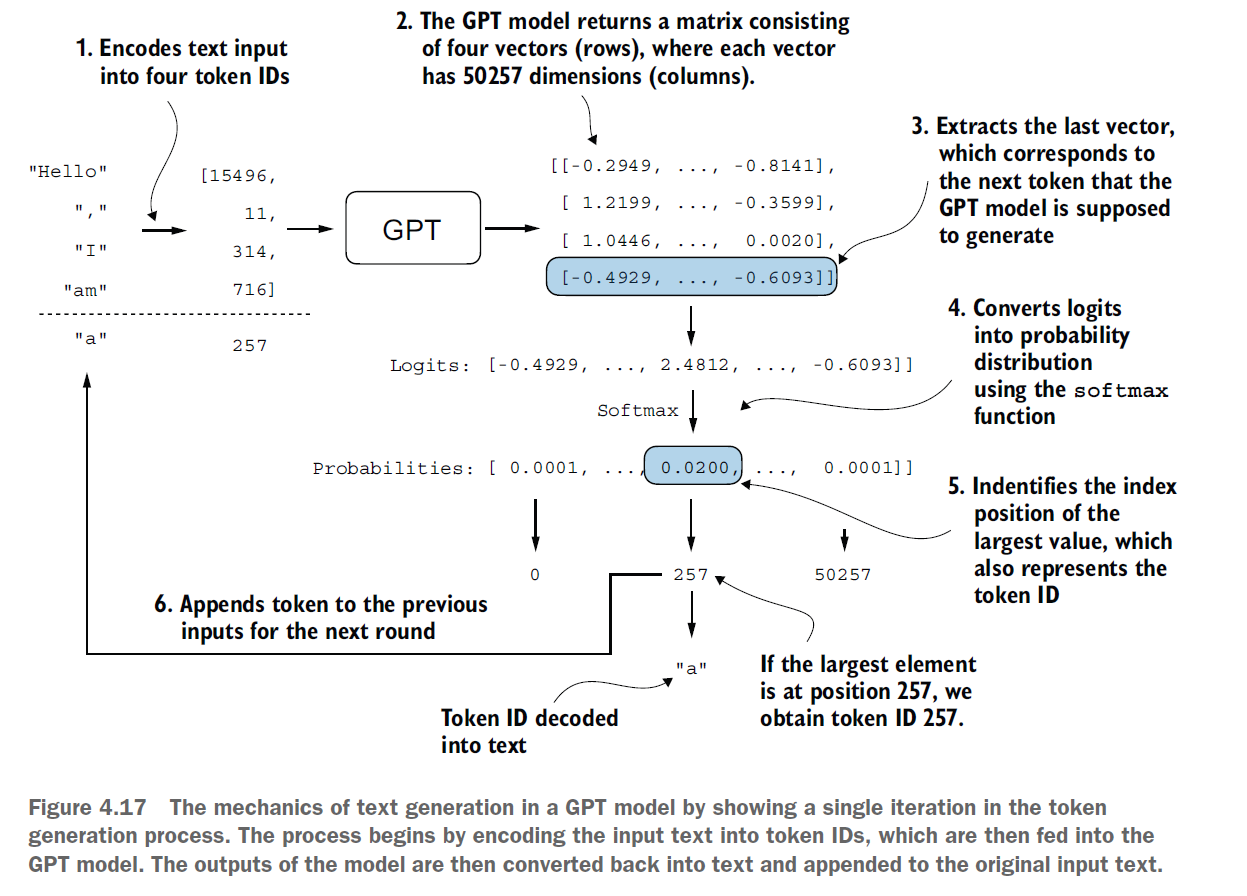

In [75]:
def generate_text_simple(model,idx,max_new_tokens,context_size): #idx is an array of indices in the current context.
    for _ in range(max_new_tokens):
        idx_cond=idx[:,-context_size:]    #Crops current context if it exceeds the supported context size
        with torch.no_grad():
            logits=model(idx_cond)
        logits=logits[:,-1,:]                # Focuses only on the last time step, so that (batch,n_token,vocab_size) 
                                             # becomes (batch,vocab_size)
        probas=torch.softmax(logits,dim=-1)                 #probas has shape(batch,vocab_size)
        idx_next=torch.argmax(probas,dim=-1,keepdim=True)   #idx_next has shape (batch,1)
        idx=torch.cat((idx,idx_next),dim=1)                 #Appends sampled index to the running sequence, where idx has shape(batch,n_tokens+1)
    
    return idx

In [76]:
start_context='Hello, I am'
encoded=tokenizer.encode(start_context)
print('encoded:',encoded)
encoded_tensor=torch.tensor(encoded).unsqueeze(0)
print('encoded_tensor.shape:',encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


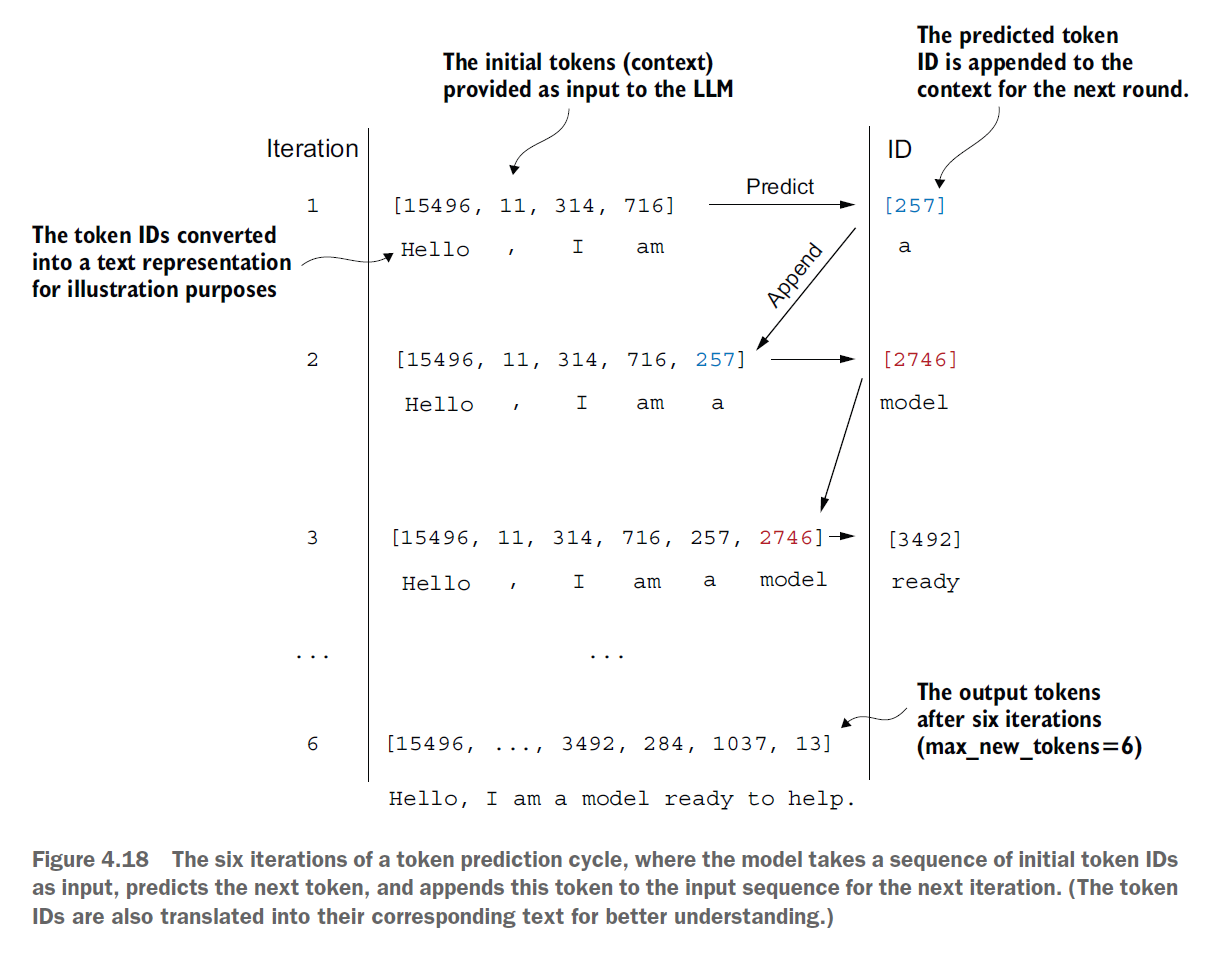

In [77]:
model.eval()
out=generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M['context_length']
)
print('Output:',out)
print('Output Length:',len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output Length: 10
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output Length: 10


In [78]:
decoded_text= tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
Hello, I am Featureiman Byeswickattribute argue


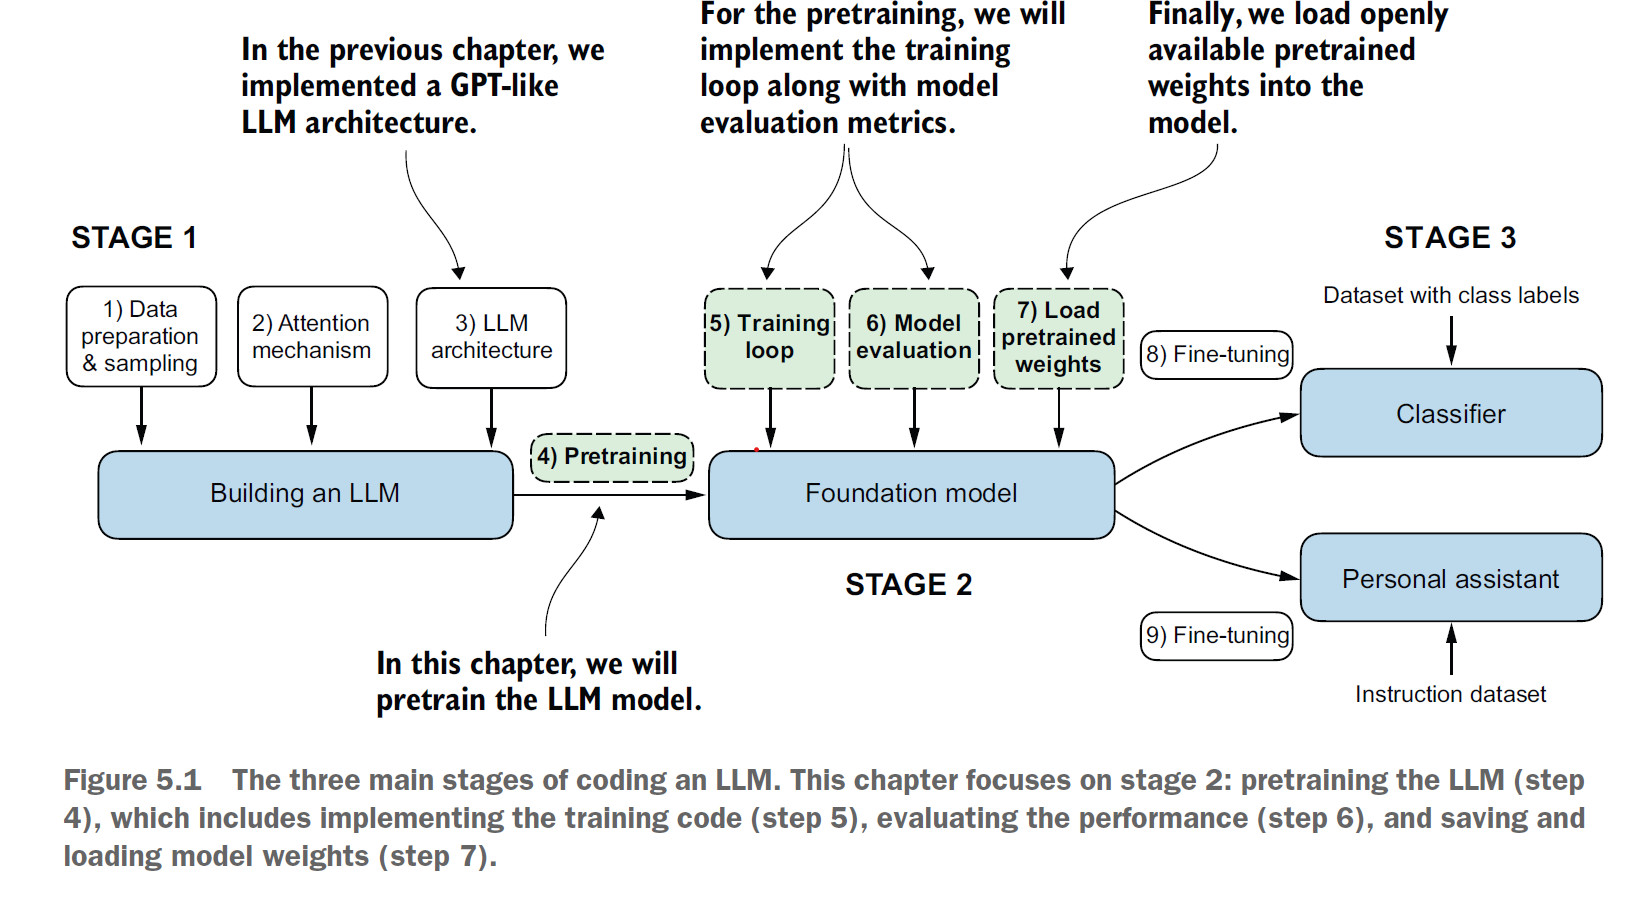

In [79]:
import torch

GPT_CONFIG_124M = {
    'vocab_size':50257,
    'context_length':256,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}

torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

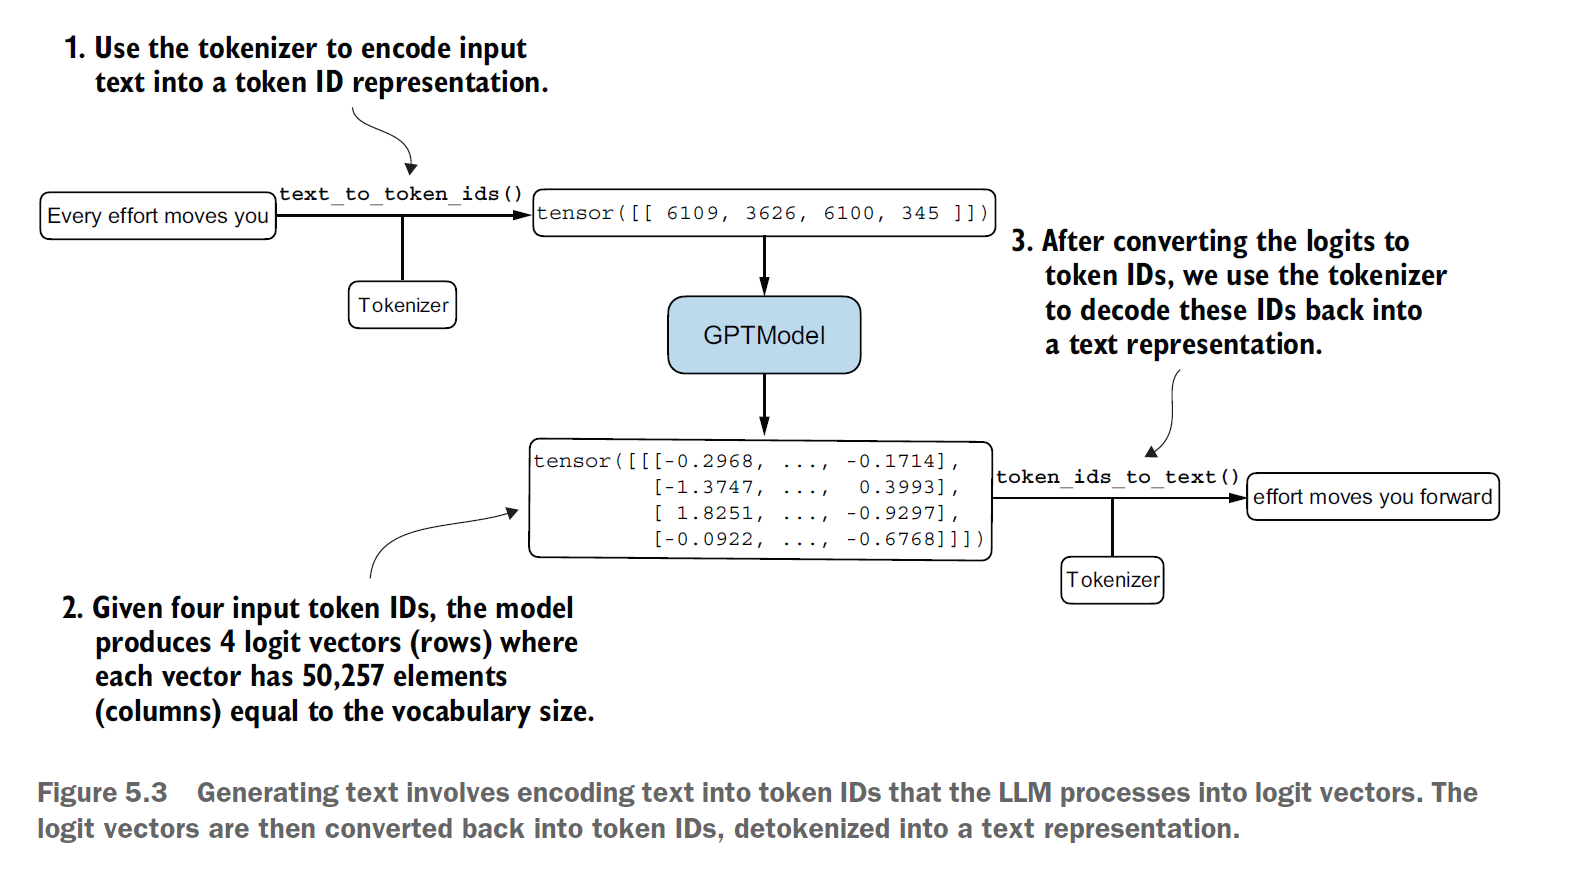

In [80]:
# Utility functions for text to token ID conversion

import tiktoken

def text_to_token_ids(text,tokenizer):
    encoded= tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor=torch.tensor(encoded).unsqueeze(0)  #.unsqueeze(0) adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat=token_ids.squeeze(0)   #Removes batch dimension
    return tokenizer.decode(flat.tolist())

start_context= 'Every effort moves you'
tokenizer= tiktoken.get_encoding('gpt2')

token_ids=generate_text_simple(
    model=model,
    idx= text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print('Output text:\n',token_ids_to_text(token_ids,tokenizer))


Output text:
 Every effort moves you Laur inhab Distrine bribes manufacture KentuckyHel revolvesNic
Output text:
 Every effort moves you Laur inhab Distrine bribes manufacture KentuckyHel revolvesNic


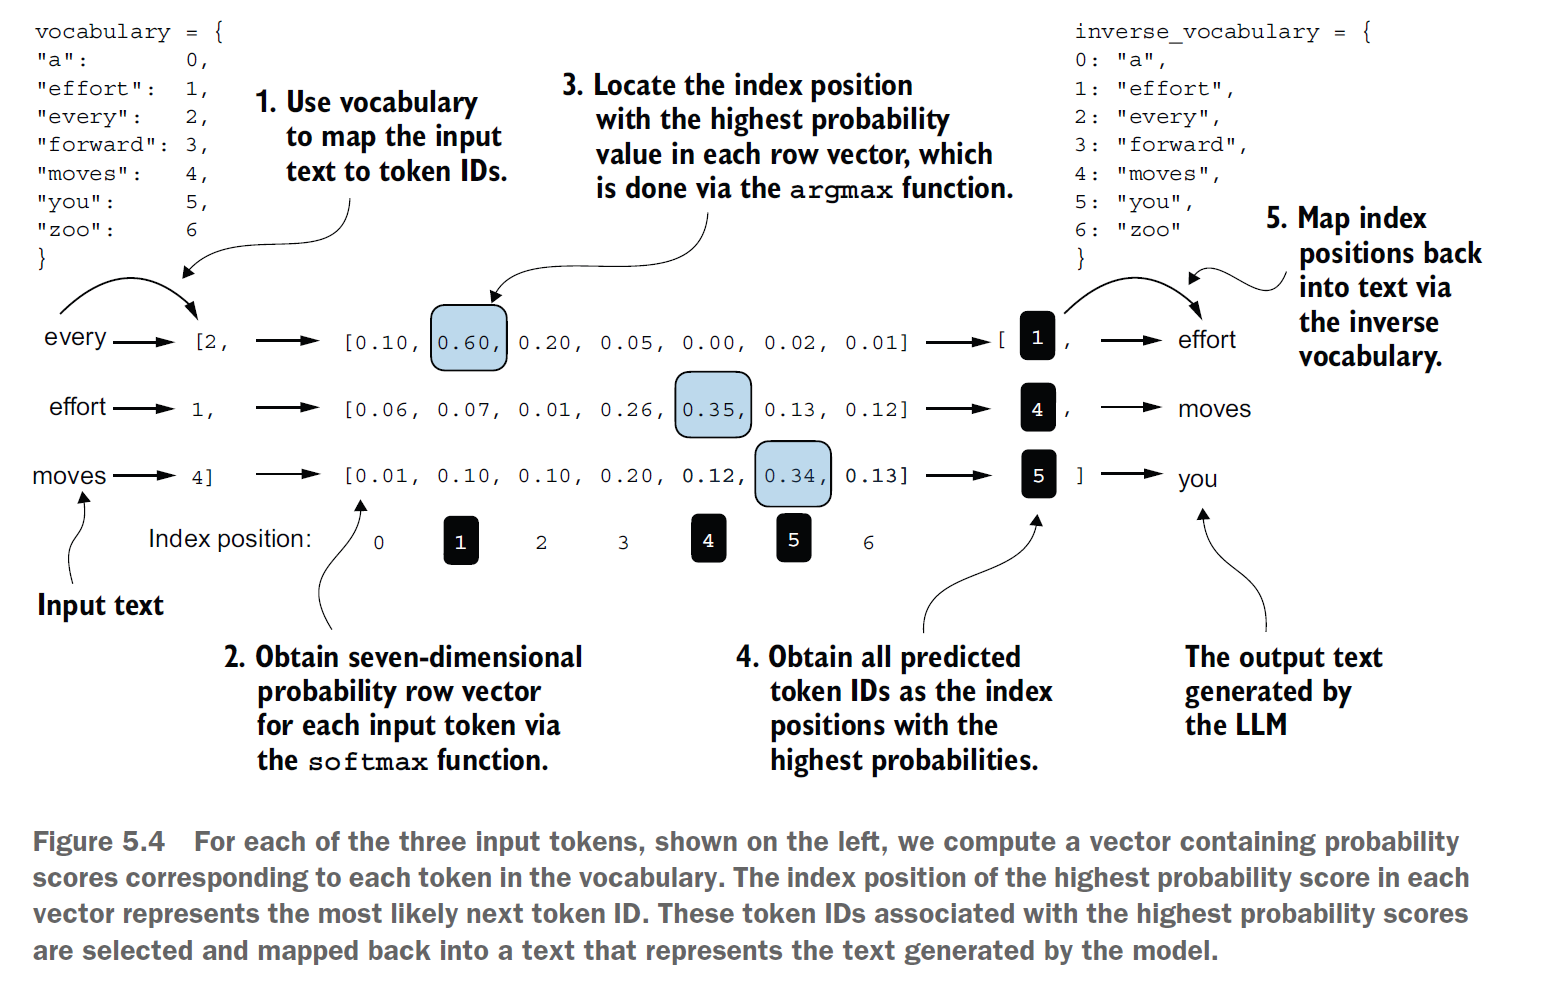

In [81]:
inputs=torch.tensor([[16833,3626,6100],    #['every effort moves',
                    [40,1107,588]])        # 'I really like']

targets=torch.tensor([[326,6100,345],   #targets contain the token IDs we want the model to produce
                    [1107,588,11311]])

In [82]:
with torch.no_grad():                 #Disables gradient tracking since we are not training yet
    logits=model(inputs)
probas=torch.softmax(logits,dim=-1)   #Probability of each token in the voabulary
print(probas.shape)

torch.Size([2, 3, 50257])torch.Size([2, 3, 50257])



In [83]:
token_ids=torch.argmax(probas,dim=-1,keepdim=True)
print('Token IDs:\n',token_ids)

Token IDs:
 tensor([[[43756],
         [16031],
         [42826]],

        [[48671],
         [16031],
         [37306]]])
Token IDs:
 tensor([[[43756],
         [16031],
         [42826]],

        [[48671],
         [16031],
         [37306]]])


In [84]:
print(f'Targets batch 1:{token_ids_to_text(targets[0],tokenizer)}')
print(f'Outputs batch 1:'
      f'{token_ids_to_text(token_ids[0].flatten(),tokenizer)}')

Targets batch 1: that moves you
Outputs batch 1: dw savesNetflix
Targets batch 1: that moves you
Outputs batch 1: dw savesNetflix


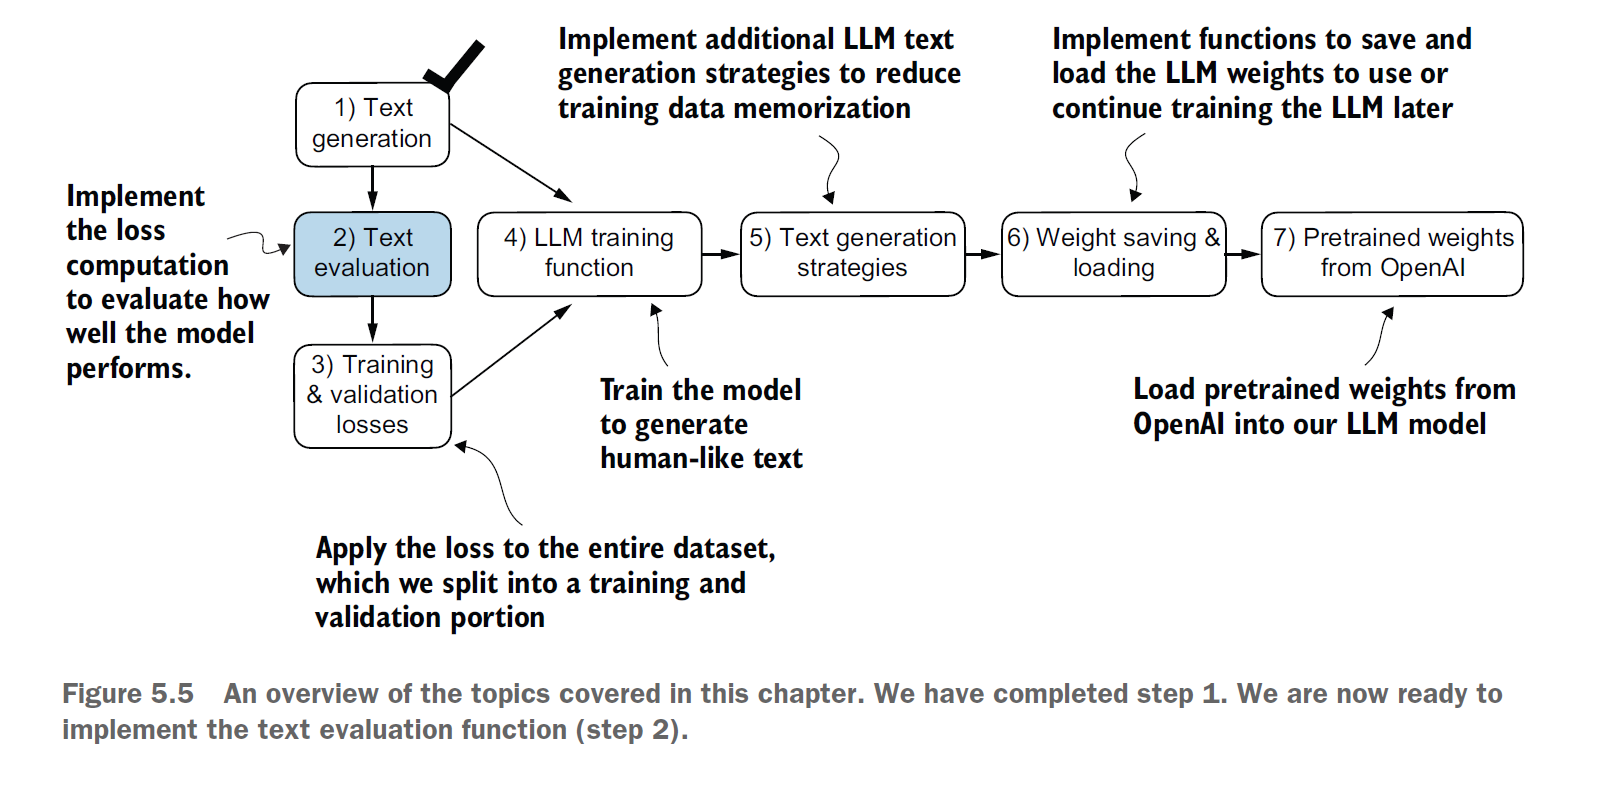

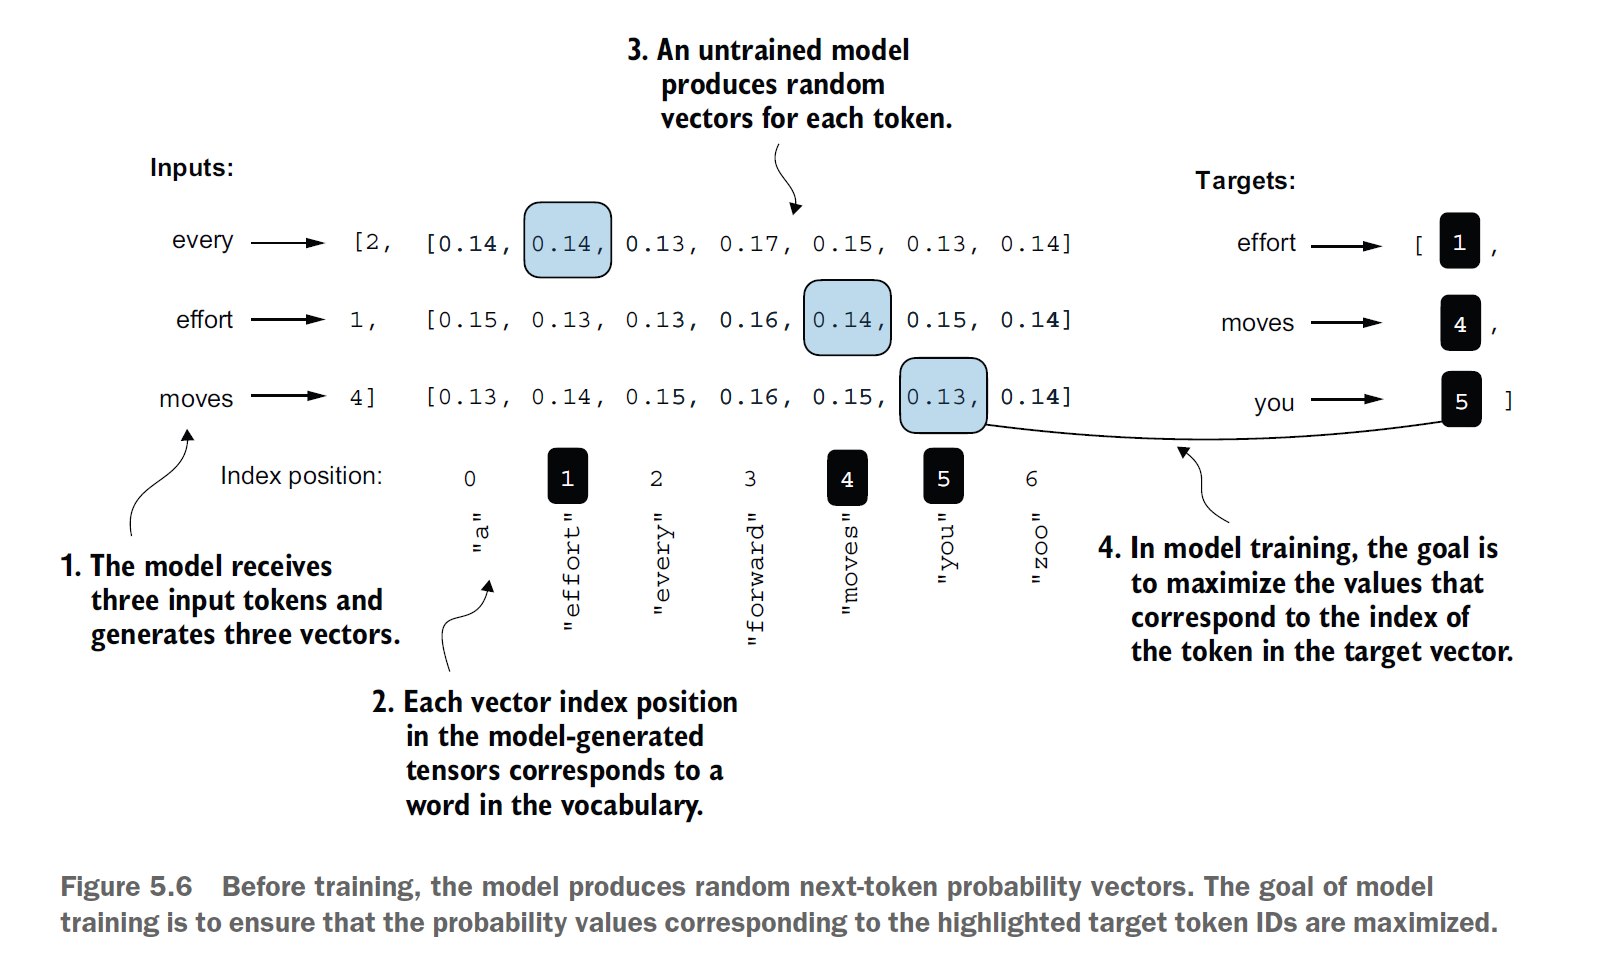

In [85]:
text_idx=0
target_probas_1=probas[text_idx,[0,1,2],targets[text_idx]]
print('Text 1:',target_probas_1)

text_idx=1
target_probas_2=probas[text_idx,[0,1,2],targets[text_idx]]
print('Text 2:',target_probas_2)

Text 1: tensor([1.7605e-05, 2.2225e-05, 1.2137e-05])
Text 2: tensor([1.2687e-05, 3.6101e-05, 4.5523e-06])
Text 1: tensor([1.7605e-05, 2.2225e-05, 1.2137e-05])
Text 2: tensor([1.2687e-05, 3.6101e-05, 4.5523e-06])


In [86]:
log_probas=torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([-10.9473, -10.7143, -11.3192, -11.2750, -10.2292, -12.2999])
tensor([-10.9473, -10.7143, -11.3192, -11.2750, -10.2292, -12.2999])


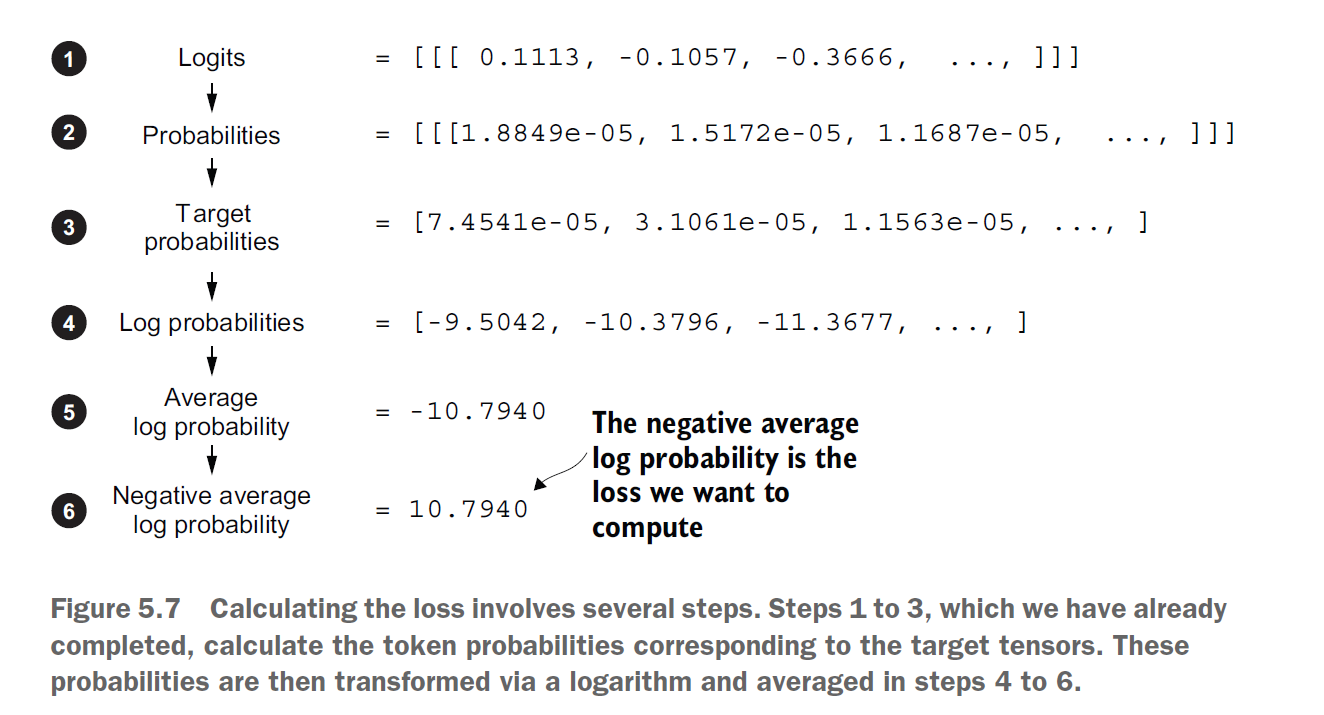

In [87]:
avg_log_probas=torch.mean(log_probas)
print(avg_log_probas)

tensor(-11.1308)
tensor(-11.1308)


In [88]:
neg_avg_log_probas=avg_log_probas * -1
print(neg_avg_log_probas)    #Cross entropy loss

tensor(11.1308)
tensor(11.1308)


In [89]:
print('Logits shape:',logits.shape)
print('Targets shape:',targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [90]:
logits_flat=logits.flatten(0,1)
targets_flat=targets.flatten()
print('Flattened logits:',logits_flat.shape)
print('Flattened targets:',targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [91]:
loss=torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(11.1308)
tensor(11.1308)


Perplexity is a measure often used alongside cross entropy loss to evaluate the performance of models in tasks like language modelling. It can provide a more interpretable way to understand the uncertainity of a model in predicting the next token in a sequence. 

Perplexity measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset. Similar to a loss, a lower perplexity indicates that the model predictions are closer to the actual distribution. 

# Calculating the training and validation set losses. 

In [92]:
file_path='the-verdict.txt'
with open(file_path,'r',encoding='utf-8') as file:
    text_data=file.read()

In [93]:
total_characters= len(text_data)
total_tokens=len(tokenizer.encode(text_data))
print('Characters:',total_characters)
print('Tokens:',total_tokens)

Characters: 20479
Tokens: 5145
Characters: 20479
Tokens: 5145


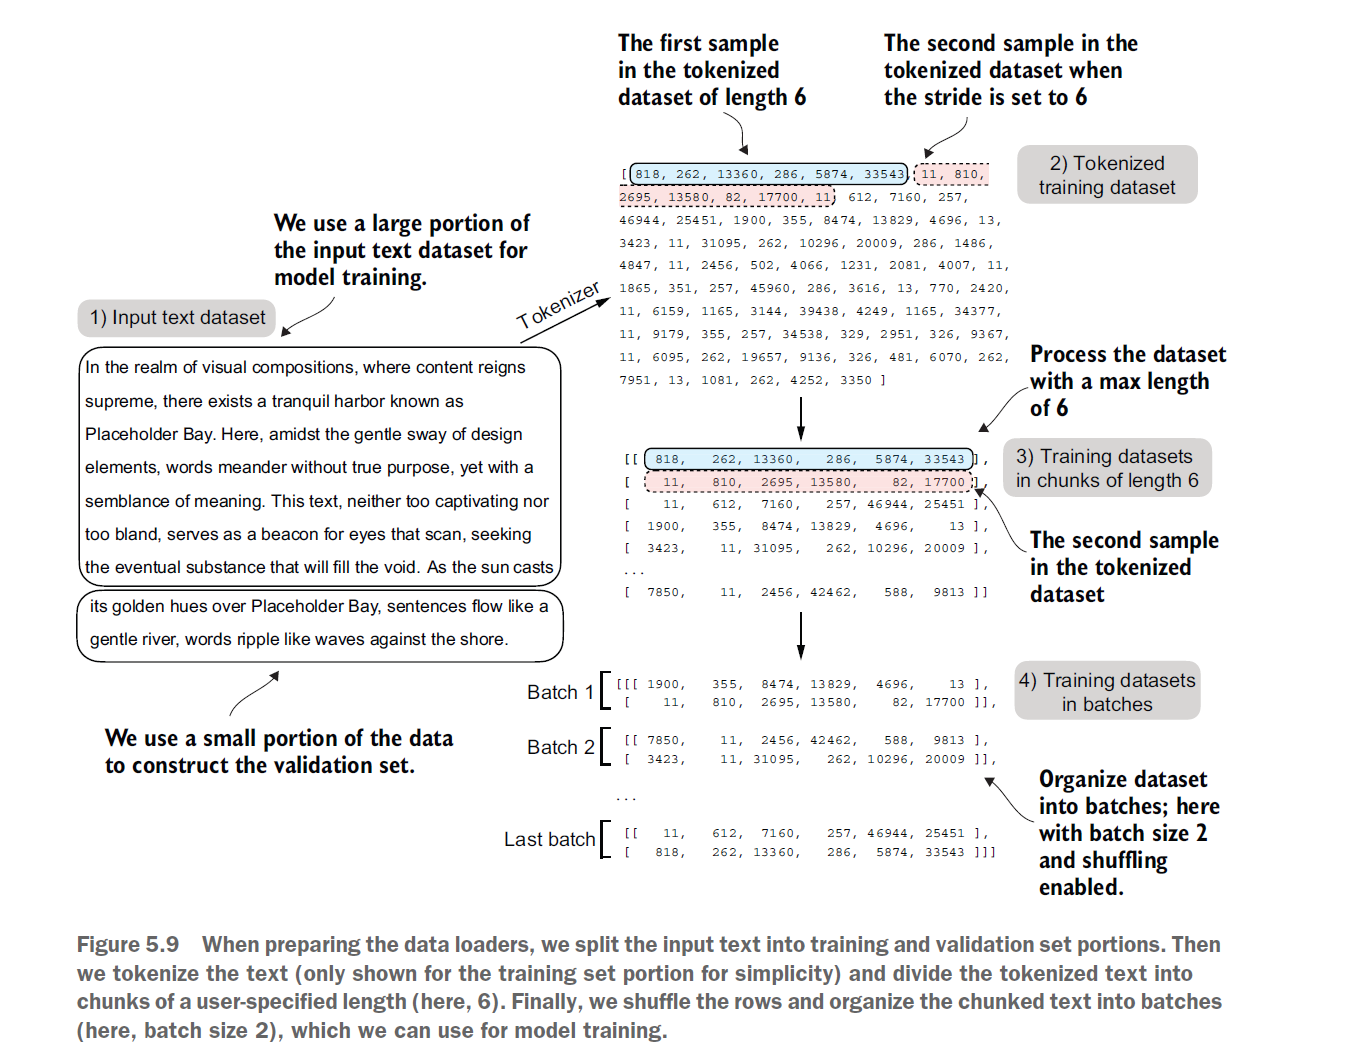

In [94]:
train_ratio=0.90
split_idx=int(train_ratio*len(text_data))
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]

In [95]:
torch.manual_seed(123)

train_loader=create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader=create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [96]:
print('Train loader:')
for x,y in train_loader:
    print(x.shape,y.shape)

print('\nValidation loader:')
for x,y in val_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [97]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch=input_batch.to(device)
    target_batch=target_batch.to(device)
    logits=model(input_batch)
    loss=torch.nn.functional.cross_entropy(
        logits.flatten(0,1),target_batch.flatten()
    )
    return loss

In [98]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss=0
    if len(data_loader) ==0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)     #Iteratives over all batches if no fixed num_batches is specified
    else:
        num_batches=min(num_batches,len(data_loader)) #reduce the no of batches to match the total number of batches in the data loader 
    for i, (input_batch,target_batch) in enumerate(data_loader): 
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch,target_batch,model,device
            )
            total_loss += loss.item()   #sums loss for each batch
        else:
            break
    return total_loss/num_batches        #Avg loss over all the batches

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss=calc_loss_loader(val_loader,model,device)
print('Training loss:',train_loss)
print('Validation loss:',val_loss)

Training loss: 10.989075342814127
Validation loss: 10.976871490478516
Training loss: 10.989075342814127
Validation loss: 10.976871490478516


# Training an LLM

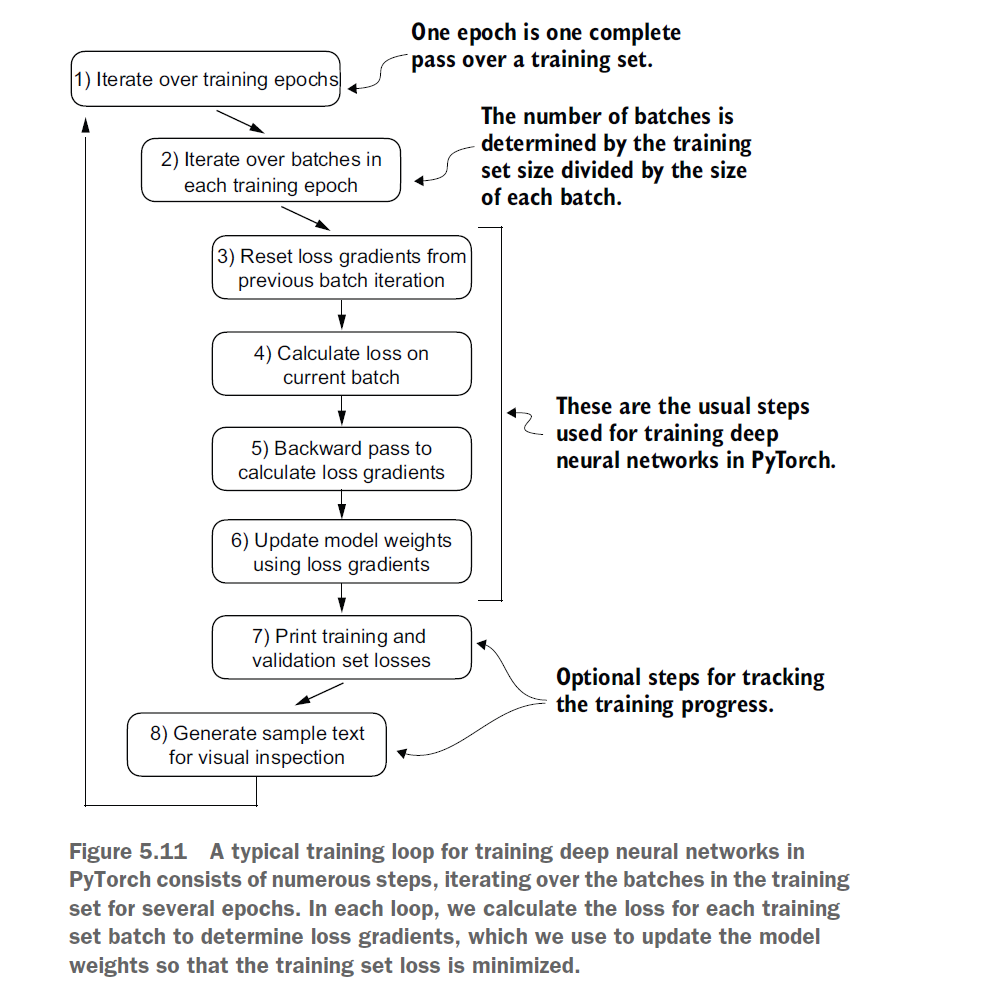

In [100]:
def train_model_simple(model,train_loader,val_loader,
                        optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
    train_losses,val_losses,track_tokens_seen=[],[],[]   #Initializes lists to track losses and tokens seen
    tokens_seen,global_step=0,-1
    
    for epoch in range(num_epochs):   #Starts the main training loop 
        model.train()
        for input_batch,target_batch in train_loader:
            optimizer.zero_grad()     #Resets loss gradients from the previous batch iteration
            loss=calc_loss_batch(
                input_batch,target_batch,model,device
            )
            loss.backward()  #Calculates loss gradients
            optimizer.step() #Updates model weights using loss gradients
            tokens_seen += input_batch.numel() 
            global_step += 1
            
            if global_step % eval_freq==0:   #Optional evaluation step
                train_loss,val_loss=evaluate_model(
                    model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}"
                    )
                
        generate_and_print_sample(      #prints a sample text after each epoch
            model,tokenizer,device,start_context
        )
    
    return train_losses,val_losses,track_tokens_seen

In [101]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()           #Dropout is disabled during evaluation for stable,reproducible results
    with torch.no_grad():   #Disables gradient tracking which is not required during evaluation to reduce the computational overhead
        train_loss=calc_loss_loader(
            train_loader,model,device,num_batches=eval_iter
        )
        val_loss=calc_loss_loader(
            val_loader,model,device,num_batches=eval_iter
        )
    model.train()
    return train_loss,val_loss

In [102]:
def generate_and_print_sample(model,tokenizer,device,start_context):
    model.eval()
    context_size=model.pos_emb.weight.shape[0]
    encoded=text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids=generate_text_simple(
            model=model,idx=encoded,
            max_new_tokens=50,context_size=context_size
        )
        decoded_text=token_ids_to_text(token_ids,tokenizer)
        print(decoded_text.replace("\n"," "))
        model.train()

In [103]:
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer= torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,weight_decay=0.1
)
num_epochs=10
train_losses,val_losses,tokens_seen=train_model_simple(
    model,train_loader,val_loader,optimizer,device,
    num_epochs=num_epochs,eval_freq=5,eval_iter=5,
    start_context="every effort moves you",tokenizer=tokenizer
)

Ep 1 (Step 000000):Train loss 9.920,Val loss 10.060
Ep 1 (Step 000000):Train loss 9.920,Val loss 10.060
Ep 1 (Step 000005):Train loss 7.932,Val loss 8.275
Ep 1 (Step 000005):Train loss 7.932,Val loss 8.275
every effort moves you,.                                                
every effort moves you,.                                                
Ep 2 (Step 000010):Train loss 6.492,Val loss 7.007
Ep 2 (Step 000010):Train loss 6.492,Val loss 7.007
Ep 2 (Step 000015):Train loss 5.880,Val loss 6.530
Ep 2 (Step 000015):Train loss 5.880,Val loss 6.530
every effort moves you, and, and the   ", and, and, and, and, and, and, and, and, and, and the, and the, and, and, and, and the, and the, and, and,
every effort moves you, and, and the   ", and, and, and, and, and, and, and, and, and, and the, and the, and, and, and, and the, and the, and, and,
Ep 3 (Step 000020):Train loss 5.001,Val loss 6.382
Ep 3 (Step 000020):Train loss 5.001,Val loss 6.382
Ep 3 (Step 000025):Train loss 4.334,Val loss 6

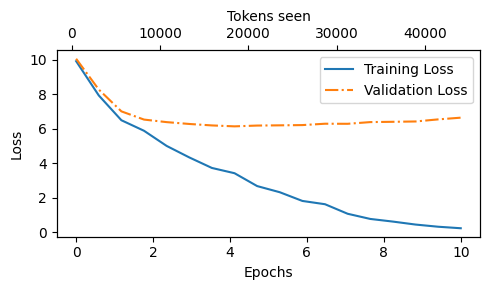

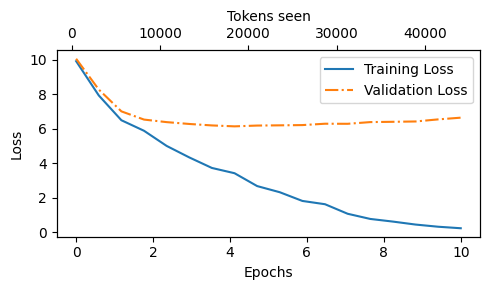

In [104]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen,tokens_seen,train_losses,val_losses):
    fig,ax1=plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen,train_losses,label='Training Loss')
    ax1.plot(epochs_seen,val_losses,linestyle='-.',label='Validation Loss')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2=ax1.twiny() #Creates a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen,train_losses,alpha=0)
    ax2.set_xlabel('Tokens seen')
    fig.tight_layout()
    plt.show()
    
epochs_tensor=torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)

# Decoding strategies to control Randomness

In [105]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [106]:
tokenizer=tiktoken.get_encoding('gpt2')
token_ids=generate_text_simple(
    model=model,
    idx=text_to_token_ids('Every effort moves you',tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)
print('Output text:\n',token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--she's an awful simpleton
Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--she's an awful simpleton


In [107]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [108]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [109]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward
forward


In [110]:
torch.manual_seed(123)
next_token_id=torch.multinomial(probas,num_samples=1).item()
print(inverse_vocab[next_token_id])

toward
toward


In [111]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
    for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
            print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


# Temperature Scaling

It is a fancy description for dividing the logits by a number greater than 0

In [112]:
def softmax_with_temperature(logits,temperature):
    scaled_logits=logits/temperature
    return torch.softmax(scaled_logits,dim=0)

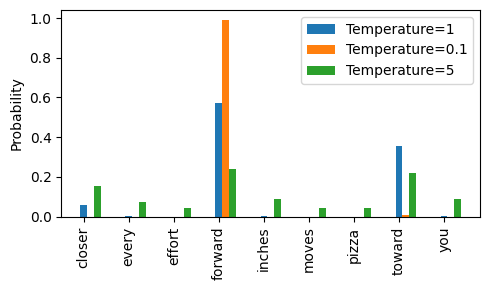

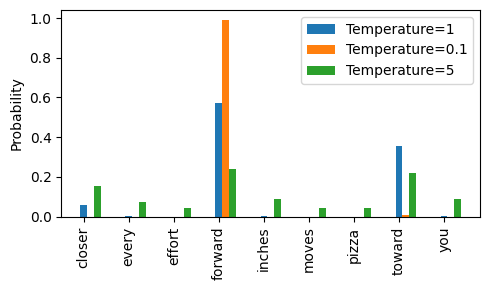

In [113]:
temperature=[1,0.1,5]
scaled_probas=[softmax_with_temperature(next_token_logits,T)
                for T in temperature]
x=torch.arange(len(vocab))
bar_width=0.15
fig,ax=plt.subplots(figsize=(5,3))
for i,T in enumerate(temperature):
    rects=ax.bar(x+i*bar_width,scaled_probas[i],
                bar_width,label=f'Temperature={T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(),rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# Top k-sampling

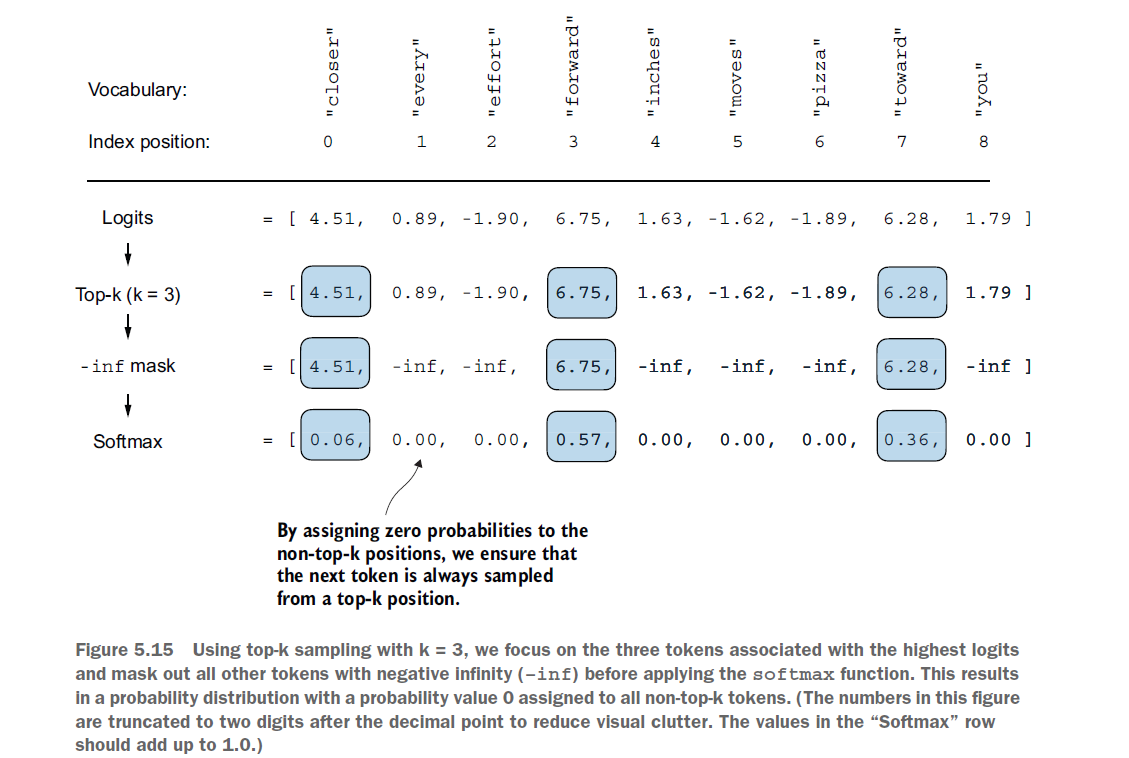

In [114]:
top_k=3
top_logits,top_pos=torch.topk(next_token_logits,top_k)
print('Top logits:',top_logits)
print('Top positions:',top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [115]:
new_logits=torch.where(
    condition=next_token_logits  <top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])



In [116]:
topk_probas=torch.softmax(new_logits,dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


# Modifying the text generation function

In [117]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond=idx[:,-context_size:]
        with torch.no_grad():
            logits=model(idx_cond)
        logits=logits[:,-1,:]
        if top_k is not None:
            top_logits,_ = torch.topk(logits,top_k)
            min_val=top_logits[:,-1]
            logits=torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
            logits
            )
        if temperature > 0.0:  #Applies temperature scaling    
            logits=logits/temperature
            probs=torch.softmax(logits,dim=-1)
            idx_next=torch.multinomial(probs,num_samples=1)
        else:                    # Carries out greedy next-token selection as before when temperature scaling is disabled   
            idx_next=torch.argmax(logits,dim=-1,keepdim=True)
        if idx_next==eos_id:    #Stops generating early if end-of-sequence token is encountered
            break
        idx=torch.cat((idx,idx_next),dim=1)
    return idx

In [118]:
torch.manual_seed(123)
token_ids=generate(
    model=model,
    idx=text_to_token_ids('Every effort moves you',tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=25,
    temperature=1.4
)
print('Output text:\n',token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you know without bitterness, and pushed one of the deep arm-chairs forward.
Output text:
 Every effort moves you know without bitterness, and pushed one of the deep arm-chairs forward.


In [119]:
torch.save(model.state_dict(),'model.pth')

In [120]:
model=GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load('model.pth',map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [121]:
torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [122]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

# Loading pretrained weights from OpenAI

In [123]:
pip install tensorflow>=2.15.0 tqdm>=4.66

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: D:\Docs\LLM\cuda\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: D:\Docs\LLM\cuda\Scripts\python.exe -m pip install --upgrade pip


In [124]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x287f6ecb1d0>)

('gpt_download.py', <http.client.HTTPMessage at 0x287f6ecb1d0>)

In [125]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
model_size="124M", models_dir="gpt2"
)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [126]:
print('Settings:',settings)
print('Parameter dictionary keys:',params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [127]:
print(params['wte'])
print('Token embedding weight tensor dimensions:',params['wte'].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  

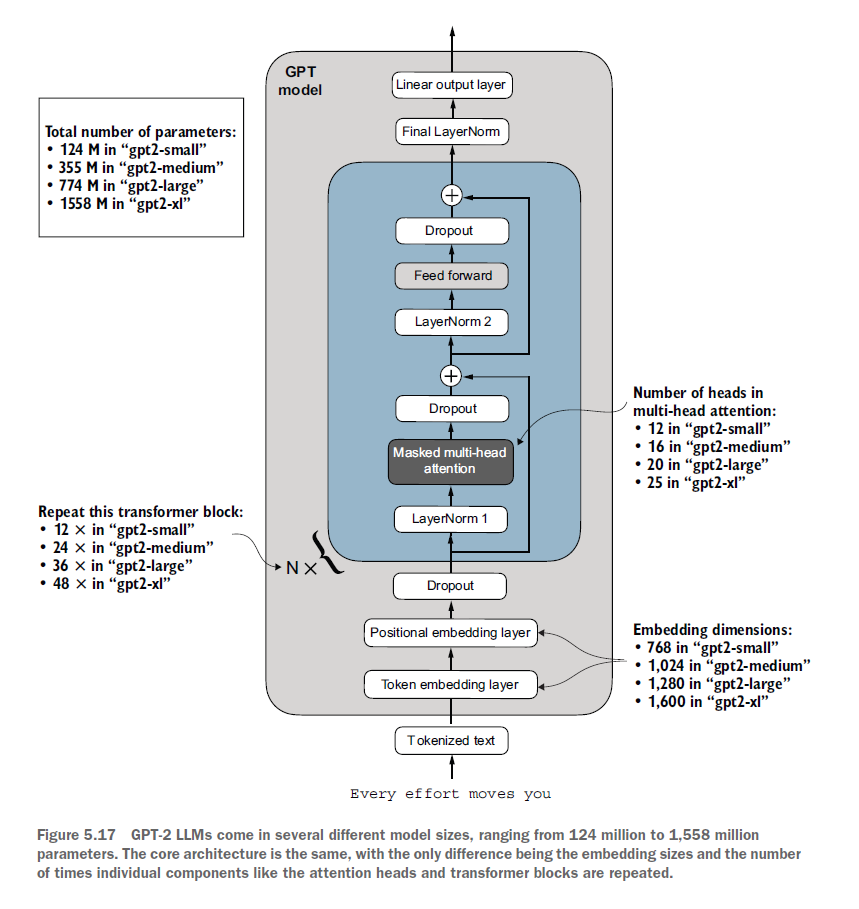

In [128]:
model_configs={
    'gpt2-small (124M)':{'emb_dim':768,'n_layers':12,'n_heads':12},
    'gpt2-medium (355M)':{'emb_dim':1024,'n_layers':24,'n_heads':16},
    'gpt2-large (774M)':{'emb_dim':1280,'n_layers':36,'n_heads':20},
    'gpt2-x1 (1558M)':{'emb_dim':1600,'n_layers':48,'n_heads':25}
}

In [129]:
model_name='gpt2-small (124M)'
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [130]:
NEW_CONFIG.update({'context_length':1024})

In [131]:
NEW_CONFIG.update({'qkv_bias':True})

In [132]:
gpt=GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [133]:
def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f'Shape mismatch.Left:{left.shape},'
                            f'Right: {right.shape}')
    return torch.nn.Parameter(torch.tensor(right))

In [134]:
import numpy as np
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
        gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
        gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
        gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
        gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
        gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
        gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
        gpt.trf_blocks[b].att.out_proj.weight,
        params["blocks"][b]["attn"]["c_proj"]["w"].T)
        
        gpt.trf_blocks[b].att.out_proj.bias = assign(
        gpt.trf_blocks[b].att.out_proj.bias,
        params["blocks"][b]["attn"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
        gpt.trf_blocks[b].ff.layers[0].weight,
        params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
        gpt.trf_blocks[b].ff.layers[0].bias,
        params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
        gpt.trf_blocks[b].ff.layers[2].weight,
        params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
        gpt.trf_blocks[b].ff.layers[2].bias,
        params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].norm1.scale = assign(
        gpt.trf_blocks[b].norm1.scale,
        params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
        gpt.trf_blocks[b].norm1.shift,
        params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
        gpt.trf_blocks[b].norm2.scale,
        params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
        gpt.trf_blocks[b].norm2.shift,
        params["blocks"][b]["ln_2"]["b"])
    
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [135]:
load_weights_into_gpt(gpt,params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [136]:
torch.manual_seed(123)
token_ids=generate(
    model=gpt,
    idx=text_to_token_ids('Every effort moves you',tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG['context_length'],
    top_k=50,
    temperature=1.5
)
print('Output text:\n',token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you as as the or beyondthe beehlenome thingyred weapon now more games it "Ecooperation-for
Output text:
 Every effort moves you as as the or beyondthe beehlenome thingyred weapon now more games it "Ecooperation-for


# Fine Tuning an LLM

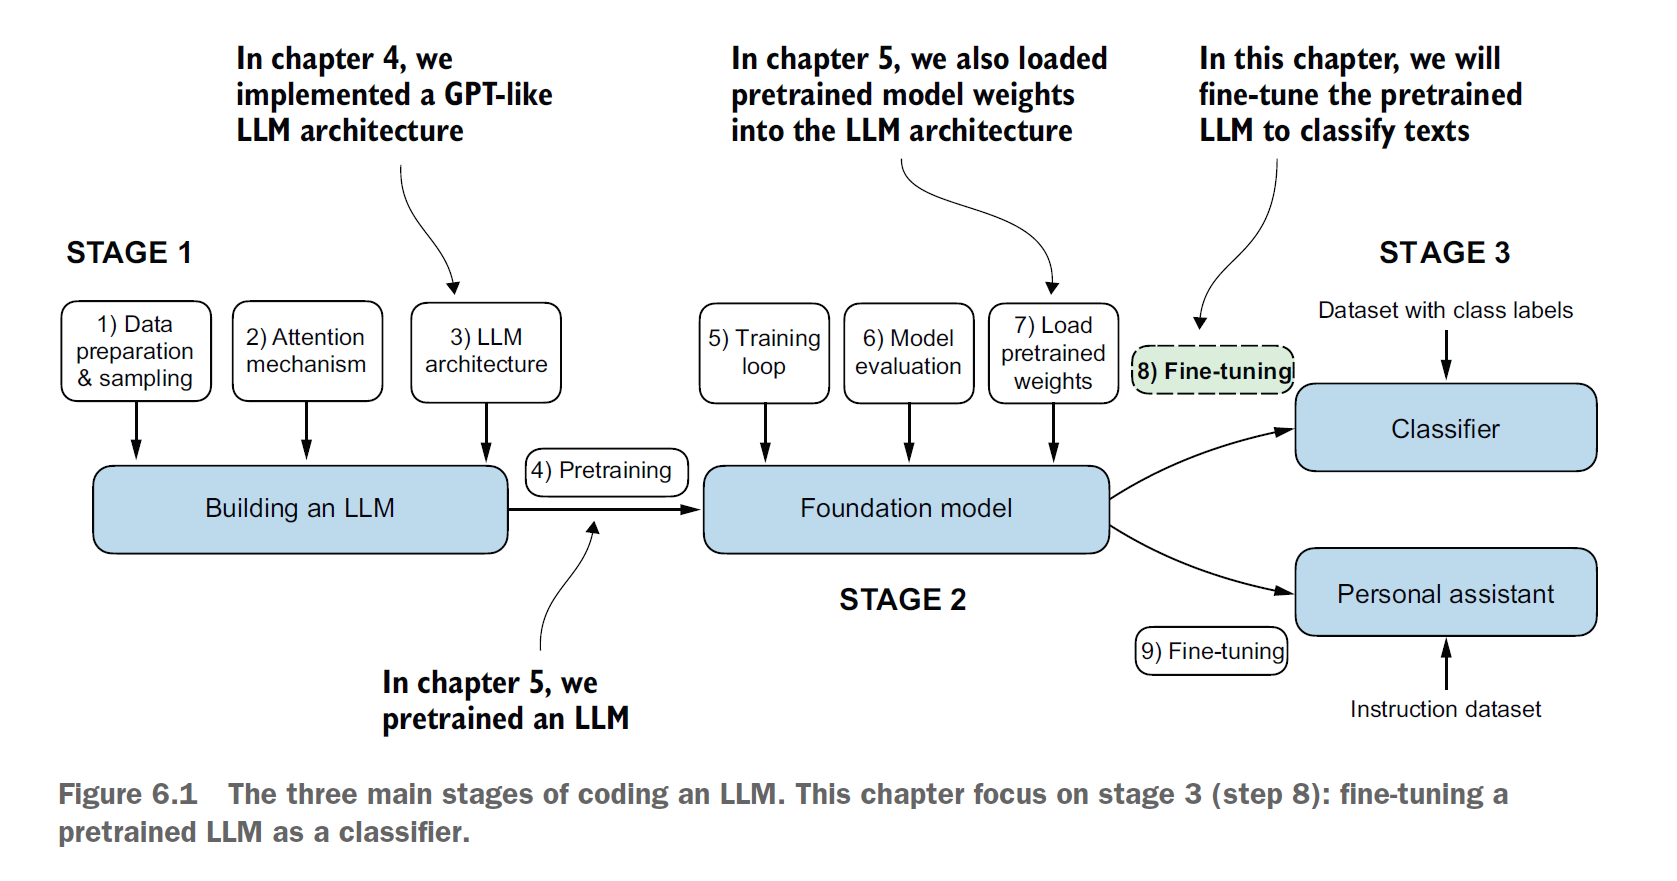

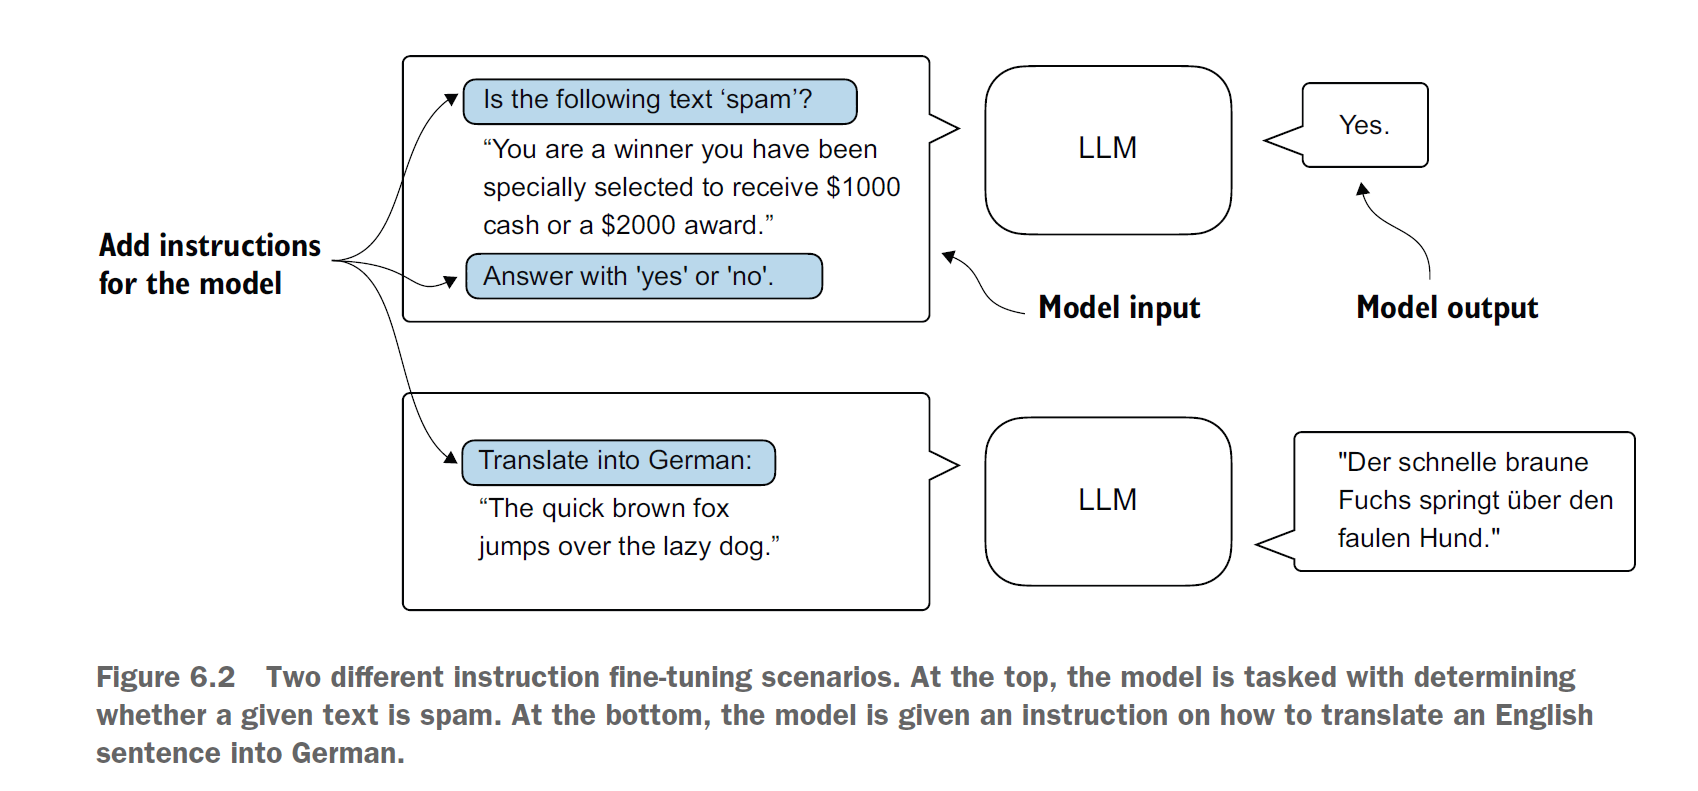

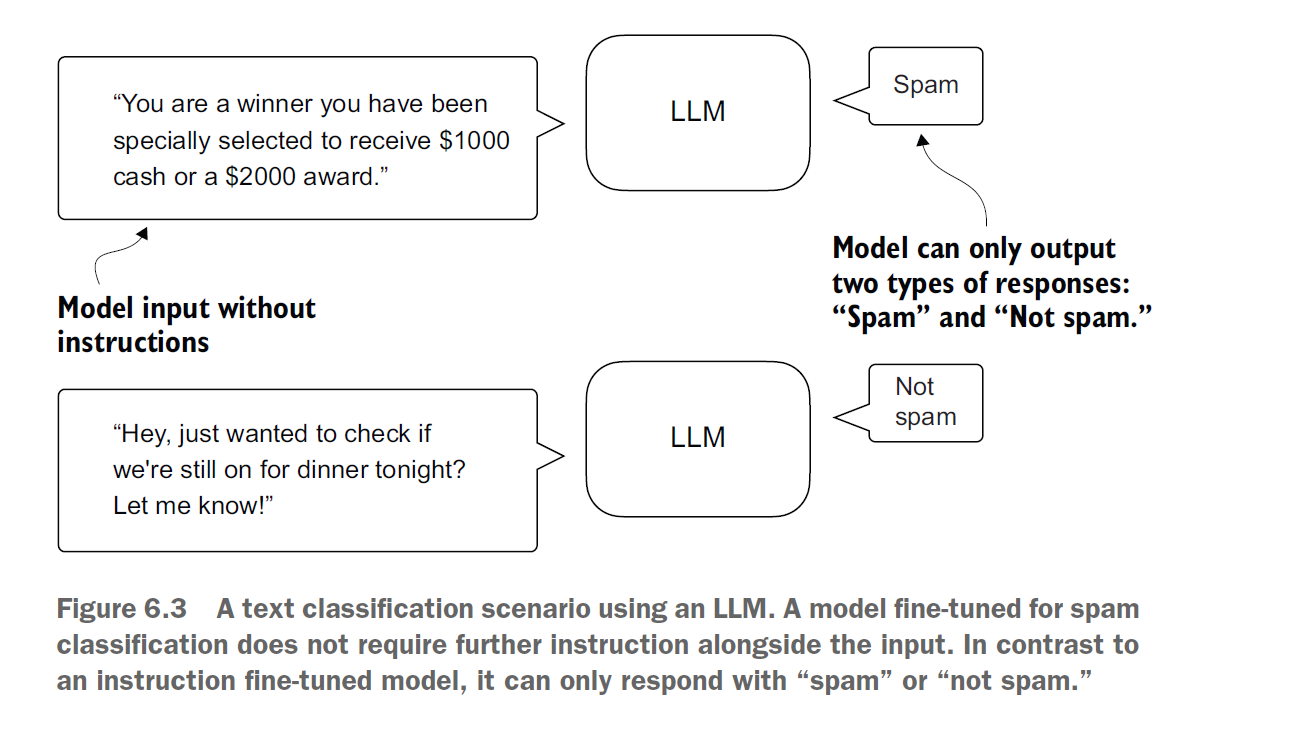

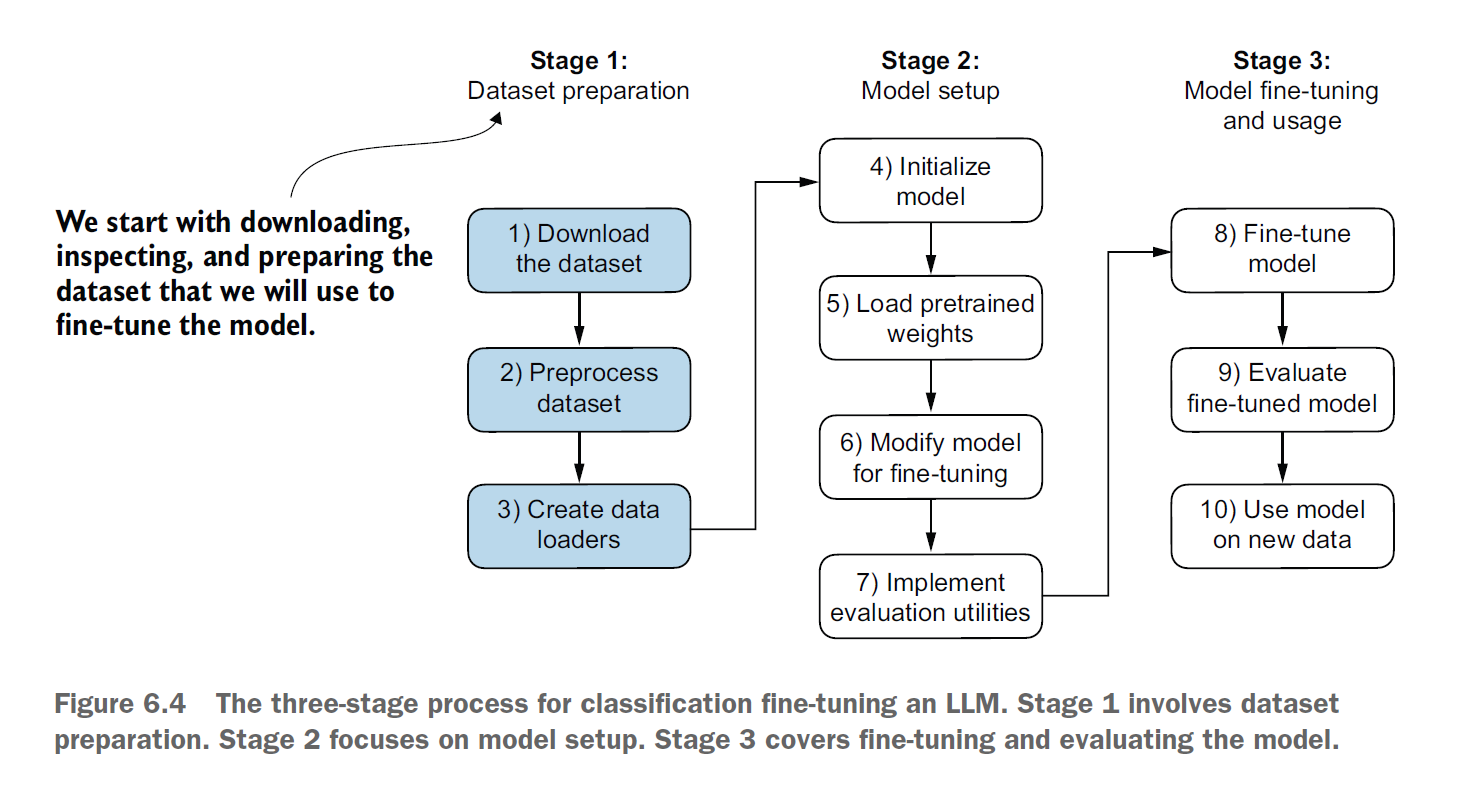

In [137]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url,zip_path,extracted_path,data_file_path):
    if data_file_path.exists():
        print(f'{data_file_path} already exists.Skipping download and extraction')
        return
    
    with urllib.request.urlopen(url) as response:      # Downloads the file
        with open(zip_path,'wb') as out_file:
            out_file.write(response.read())
            
    with zipfile.ZipFile(zip_path,'r') as zip_ref:     # Unzips the file
        zip_ref.extractall(extracted_path)
        
    original_file_path=Path(extracted_path) / 'SMSSpamCollection'    # Adds a .tsv file extension
    os.rename(original_file_path,data_file_path)
    print(f'File downloaded and saved as {data_file_path}')
    
download_and_unzip_spam_data(url,zip_path,extracted_path,data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists.Skipping download and extraction
sms_spam_collection\SMSSpamCollection.tsv already exists.Skipping download and extraction


In [138]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: D:\Docs\LLM\cuda\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: D:\Docs\LLM\cuda\Scripts\python.exe -m pip install --upgrade pip


In [139]:
import pandas as pd

df=pd.read_csv(
    data_file_path,sep='\t',header=None,names=['Label','Text']
)
df

Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [140]:
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64
Label
ham     4825
spam     747
Name: count, dtype: int64


In [141]:
def create_balanced_dataset(df):
    num_spam=df[df['Label']=='spam'].shape[0]
    ham_subset=df[df['Label']=='ham'].sample(
        num_spam,random_state=123)
    balanced_df=pd.concat([ham_subset,df[df['Label']=='spam']])
    return balanced_df

balanced_df=create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64
Label
ham     747
spam    747
Name: count, dtype: int64


In [142]:
balanced_df['Label'] = balanced_df['Label'].map({'ham':0,'spam':1})

In [143]:
#Splitting the dataset

def random_split(df,train_frac,validation_frac):
    
    df=df.sample(frac=1,random_state=123).reset_index(drop=True)
    train_end=int(len(df) * train_frac)
    validation_end=train_end + int(len(df) * validation_frac)
    
    train_df=df[:train_end]
    validation_df=df[train_end:validation_end]
    test_df=df[validation_end:]
    
    return train_df,validation_df,test_df

train_df,validation_df,test_df=random_split(balanced_df,0.7,0.1)

In [144]:
train_df.to_csv('train.csv',index=None)
validation_df.to_csv('validation.csv',index=None)
test_df.to_csv('test.csv',index=None)

# Creating data loaders

In [145]:
import tiktoken
tokenizer= tiktoken.get_encoding('gpt2')
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]
[50256]


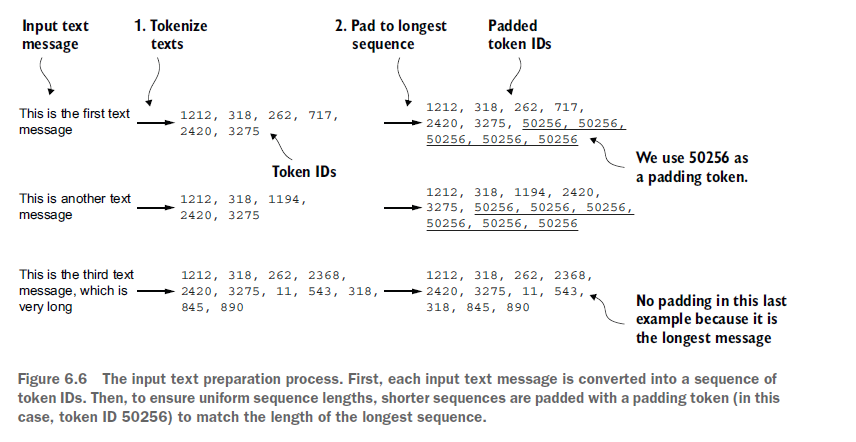

In [146]:
# Setting up a PyTorch Dataset class

import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self,csv_file,tokenizer,max_length=None,pad_token_id=50256):
        self.data=pd.read_csv(csv_file)
        
        self.encoded_texts=[tokenizer.encode(text) for text in self.data['Text']]
        
        if max_length is None:
            self.max_length=self._longest_encoded_length()
        else:
            self.max_length=max_length
            
            self.encoded_texts=[
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
            
        self.encoded_texts= [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
        
    def __getitem__(self,index):
        encoded=self.encoded_texts[index]
        label=self.data.iloc[index]['Label']
        return (
            torch.tensor(encoded,dtype=torch.long),
            torch.tensor(label,dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length=0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length 

In [147]:
train_dataset= SpamDataset(
    csv_file='train.csv',
    max_length=None,
    tokenizer=tokenizer
)

In [148]:
print(train_dataset.max_length)

120
120


In [149]:
val_dataset=SpamDataset(
    csv_file='validation.csv',
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset=SpamDataset(
    csv_file='test.csv',
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

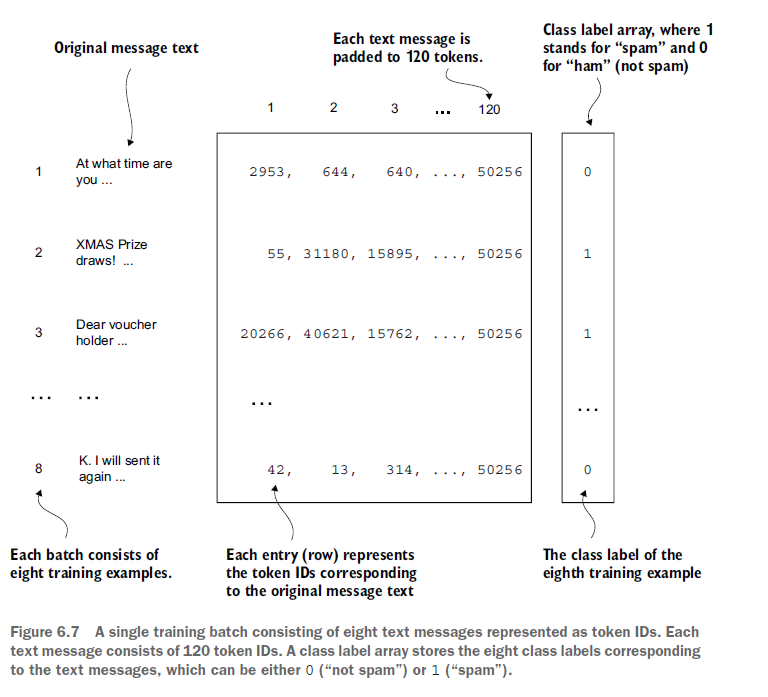

In [150]:
#Creating PyTorch Data Loaders

from torch.utils.data import DataLoader

num_workers=0     # This setting ensures compatibility with most computers
batch_size=8
torch.manual_seed(123)

train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [151]:
for input_batch,target_batch in train_loader:
    pass
print('Input batch dimensions:',input_batch.shape)
print('Label batch dimensions:',target_batch.shape)

Input batch dimensions:Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])
 torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [152]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches
130 training batches
19 validation batches
38 test batches


# Initializing a model with pretrained weights

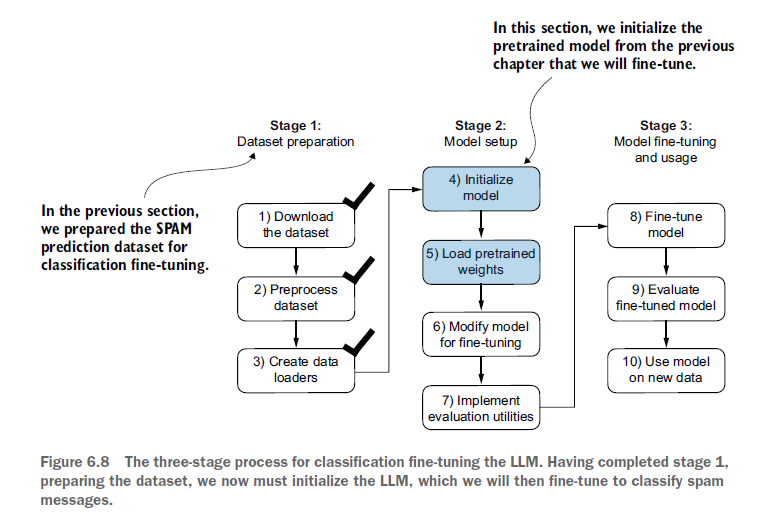

In [153]:
choose_model='gpt2-small (124M)'
input_prompt='Evert effort moves'

In [154]:
base_config={
    'vocab_size':50257,
    'context_length':1024,
    'drop_rate':0.0,
    'qkv_bias':True
}

model_configs={
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

base_config.update(model_configs[choose_model])

In [155]:
# Loading a pretrained GPT model

from gpt_download import download_and_load_gpt2

model_size = choose_model.split(" ")[-1].lstrip("(").rstrip(")")
settings,params=download_and_load_gpt2(
    model_size=model_size,models_dir='gpt2'
)

model=GPTModel(base_config)
load_weights_into_gpt(model,params)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [156]:
text_1='Every effort moves you'
token_ids=generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1,tokenizer),
    max_new_tokens=15,
    context_size= base_config['context_length']
)

print(token_ids_to_text(token_ids,tokenizer))

Every effort moves you, and the the way back to but notepadate-related issues a
Every effort moves you, and the the way back to but notepadate-related issues a


In [157]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids(text_2, tokenizer),
max_new_tokens=23,
context_size=base_config["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'siumfaultly falsely or the,,,,, the the thement us, thement them
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'siumfaultly falsely or the,,,,, the the thement us, thement them


# Adding a classification head

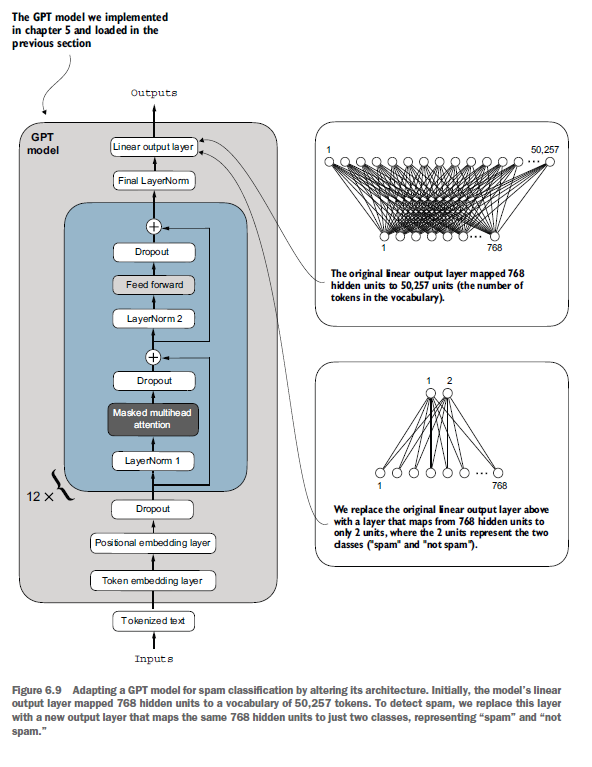

In [158]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [159]:
for param in model.parameters():
    param.requires_grad=False

In [160]:
# Adding a classification layer
torch.manual_seed(123)
num_classes=2
model.out_head=torch.nn.Linear(
    in_features=base_config['emb_dim'],
    out_features=num_classes
)

In [161]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad=True
for param in model.final_norm.parameters():
    param.requires_grad=True

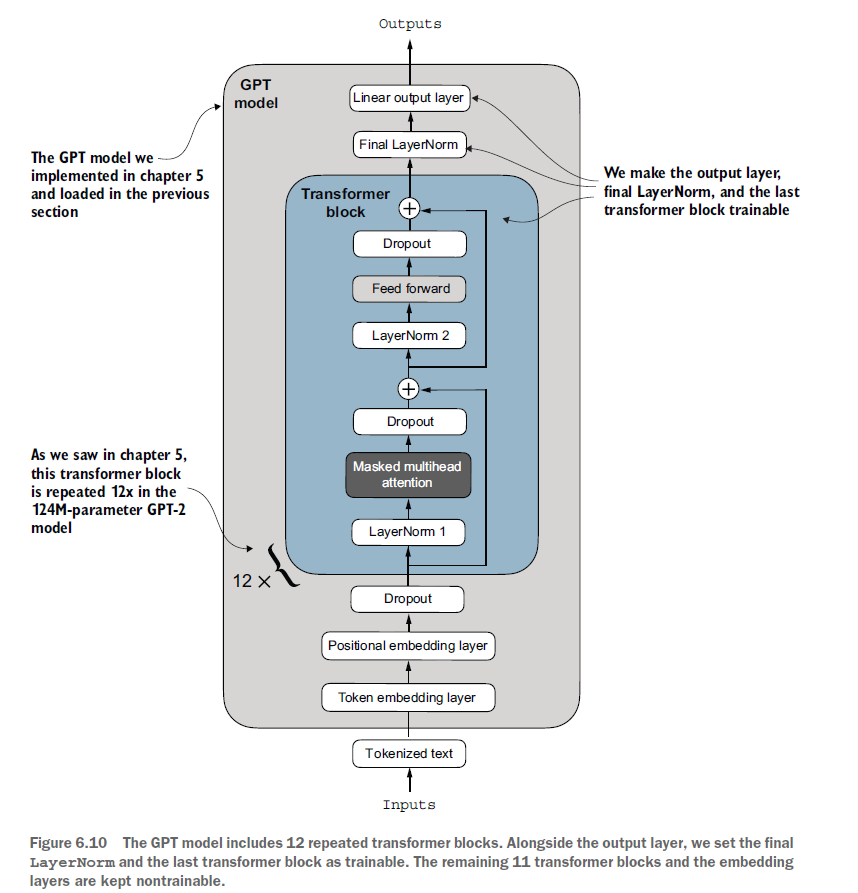

In [162]:
inputs=tokenizer.encode('Do you have time')
inputs=torch.tensor(inputs).unsqueeze(0)
print("Inputs:",inputs)
print('Inputs dimensions:',inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [163]:
with torch.no_grad():
    outputs=model(inputs)
print('outputs:\n',outputs)
print('Outputs dimensions:',outputs.shape)

outputs:
 tensor([[[-3.3088e-01,  4.8109e-02],
         [-3.9202e+00,  4.9823e+00],
         [-7.7774e-01,  4.7058e-03],
         [-1.7863e+00,  3.4001e+00]]])
Outputs dimensions: torch.Size([1, 4, 2])
outputs:
 tensor([[[-3.3088e-01,  4.8109e-02],
         [-3.9202e+00,  4.9823e+00],
         [-7.7774e-01,  4.7058e-03],
         [-1.7863e+00,  3.4001e+00]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [164]:
print('last output token:',outputs[:,-1,:])

last output token: tensor([[-1.7863,  3.4001]])
last output token: tensor([[-1.7863,  3.4001]])


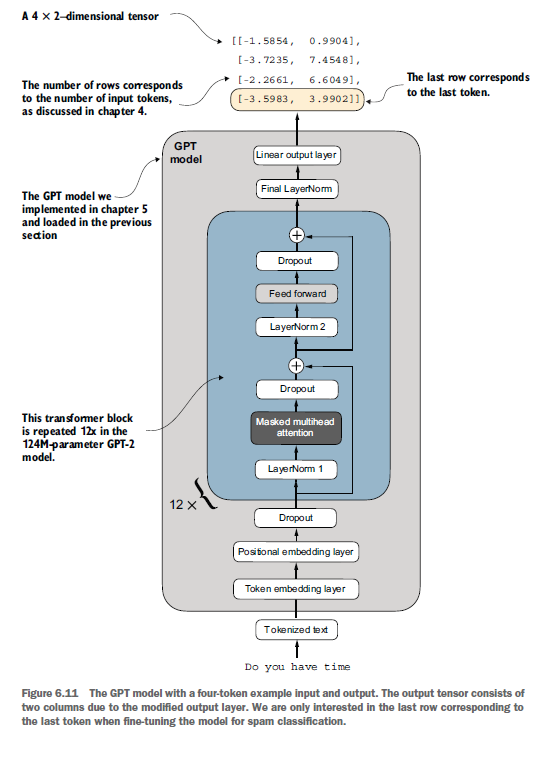

# Calculating the classification loss and accuracy

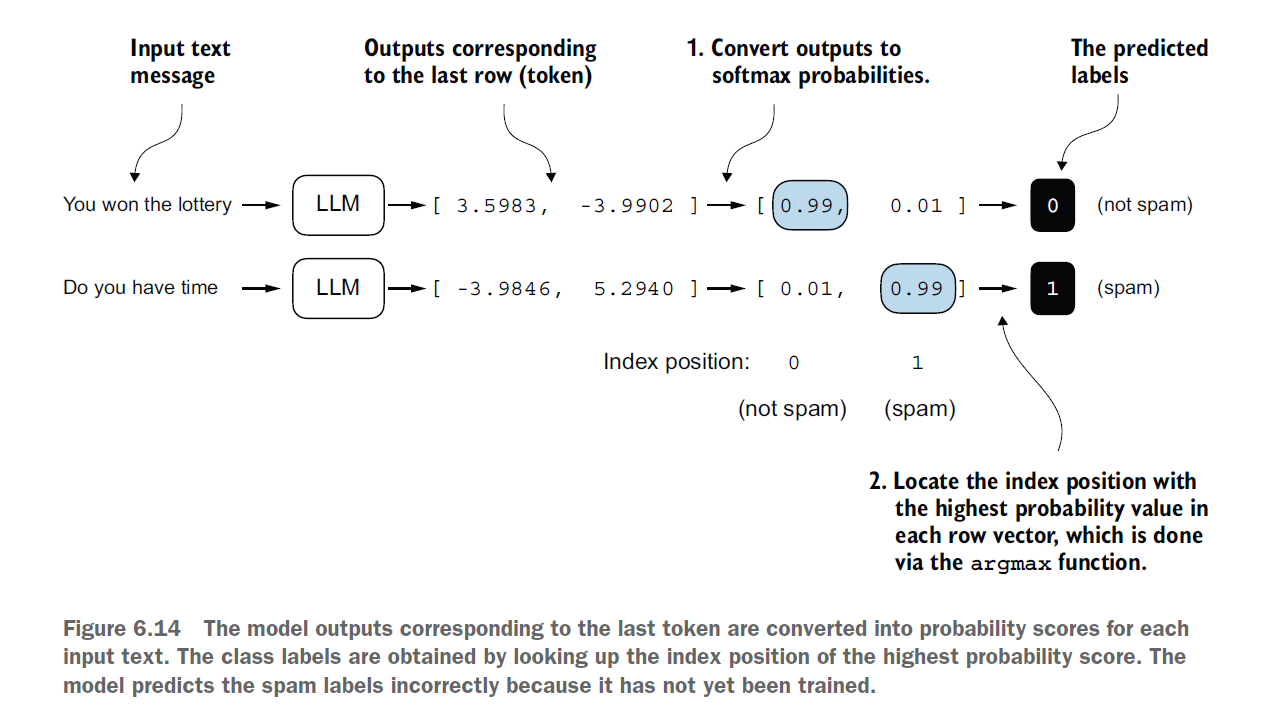

In [165]:
print('Last output token:',outputs[:,-1,:])

Last output token: tensor([[-1.7863,  3.4001]])
Last output token: tensor([[-1.7863,  3.4001]])


In [166]:
probas=torch.softmax(outputs[:,-1,:],dim=-1)
label=torch.argmax(probas)
print('Class label:',label.item())

Class label: 1
Class label: 1


In [167]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1
Class label: 1


In [170]:
# Calculating the classification accuracy

def calc_accuracy_loader(data_loader, model, device, num_batches=10):
    model.to(device)  # Ensure model is on the same device
    model.eval()
    num_correct, num_examples = 0, 0

    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break

            # Move inputs and targets to the same device as the model
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_correct += (predicted_labels == target_batch).sum().item()
            num_examples += predicted_labels.shape[0]

    return num_correct / num_examples if num_examples > 0 else 0

In [171]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 38.75%
Validation accuracy: 40.00%
Test accuracy: 47.50%
Training accuracy: 38.75%
Validation accuracy: 40.00%
Test accuracy: 47.50%


In [172]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch=input_batch.to(device)
    target_batch=target_batch.to(device)
    logits=model(input_batch)[:,-1,:]  #Logits of the last output token
    loss=torch.nn.functional.cross_entropy(logits,target_batch)
    return loss

In [173]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss=0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches=min(num_batches,len(data_loader))   #Ensure number of batches doesn't exceed batches in data loader
        
    for i, (input_batch,target_batch) in enumerate (data_loader):
        if i < num_batches:
            loss= calc_loss_batch(
                input_batch,target_batch,model,device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [176]:
with torch.no_grad():
    train_loss= calc_loss_loader(
        train_loader,model,device,num_batches=5
    )
    val_loss= calc_loss_loader(val_loader,model,device,num_batches=5)
    test_loss= calc_loss_loader(test_loader,model,device,num_batches=5)
print(f"Training loss: {train_loss:.2f}")
print(f"Validation loss: {val_loss:.2f}")
print(f"Test loss: {test_loss:.2f}")

Training loss: 1.16
Validation loss: 1.55
Test loss: 1.27
Training loss: 1.16
Validation loss: 1.55
Test loss: 1.27


# Fine tuning the model on supervised data

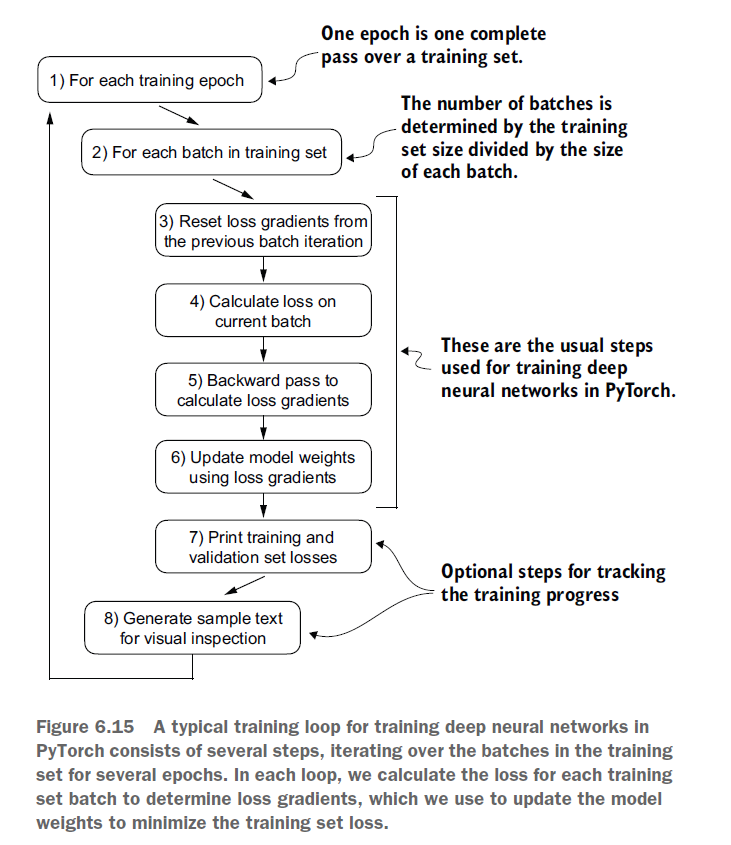

In [180]:
def train_classifier_simple(
    model,train_loader,val_loader,optimizer,device,
    num_epochs,eval_freq,eval_iter):
    train_losses,val_losses,train_accs,val_accs=[],[],[],[]
    examples_seen,global_step=0,-1
    
    for epoch in range(num_epochs):    # Main training loop
        model.train()                  # Sets model to training mode
        
        for input_batch,target_batch in train_loader:    
            optimizer.zero_grad()                       # Resets loss gradients from the previous batch iteration
            loss=calc_loss_batch(
                input_batch,target_batch,model,device
            )
            loss.backward()           #Calculates loss gradients
            optimizer.step()          # Updates model weights using loss gradients
            examples_seen += input_batch.shape[0]   #Tracks examples instead of tokens
            global_step += 1
            
            #Optinal evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f'Ep {epoch+1} (Step {global_step:06d}):'
                      f'Train loss {train_loss:.3f},'
                      f'Val loss {val_loss:.3f}'
                     )
                
        train_accuracy = calc_accuracy_loader(
            train_loader,model,device,num_batches=eval_iter
        )
        val_accuracy=calc_accuracy_loader(
            val_loader,model,device,num_batches=eval_iter
        )
        print(f'Training accuracy:{train_accuracy*100:.2f}%| ',end="")
        print(f'Validation accuracy: {val_accuracy*100:.2f}%')
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses,val_losses,train_accs,val_accs,examples_seen

In [178]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        
        train_loss= calc_loss_loader(
            train_loader,model,device,num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader,model,device,num_batches=eval_iter
        )
    
    model.train()
    return train_loss,val_loss

In [181]:
import time

start_time= time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(),lr = 5e-5,weight_decay=0.1)
num_epochs=5

train_losses,val_losses,train_accs,val_accs,examples_seen = train_classifier_simple(
    model,train_loader,val_loader,optimizer,device,num_epochs=num_epochs,eval_freq=50,eval_iter=5)

end_time=time.time()
execution_time_minutes= (end_time-start_time) / 60
print(f'Training completed in {execution_time_minutes:.2f} minutes.')

Ep 1 (Step 000000):Train loss 1.043,Val loss 1.339
Ep 1 (Step 000000):Train loss 1.043,Val loss 1.339
Ep 1 (Step 000050):Train loss 0.372,Val loss 0.645
Ep 1 (Step 000050):Train loss 0.372,Val loss 0.645
Ep 1 (Step 000100):Train loss 0.319,Val loss 0.533
Ep 1 (Step 000100):Train loss 0.319,Val loss 0.533
Training accuracy:85.00%| Validation accuracy: 77.50%
Training accuracy:85.00%| Validation accuracy: 77.50%
Ep 2 (Step 000150):Train loss 0.435,Val loss 0.507
Ep 2 (Step 000150):Train loss 0.435,Val loss 0.507
Ep 2 (Step 000200):Train loss 0.326,Val loss 0.502
Ep 2 (Step 000200):Train loss 0.326,Val loss 0.502
Ep 2 (Step 000250):Train loss 0.198,Val loss 0.531
Ep 2 (Step 000250):Train loss 0.198,Val loss 0.531
Training accuracy:90.00%| Validation accuracy: 75.00%
Training accuracy:90.00%| Validation accuracy: 75.00%
Ep 3 (Step 000300):Train loss 0.203,Val loss 0.481
Ep 3 (Step 000300):Train loss 0.203,Val loss 0.481
Ep 3 (Step 000350):Train loss 0.291,Val loss 0.433
Ep 3 (Step 000350):

# Plotting the classification loss

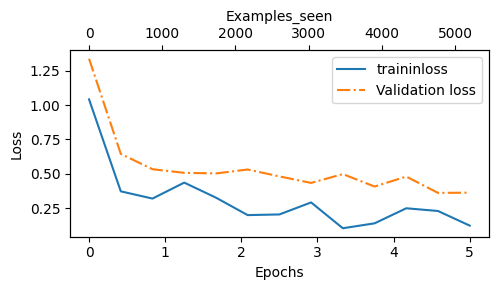

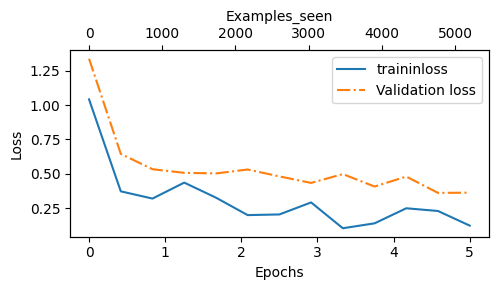

In [185]:
import matplotlib.pyplot as plt

def plot_values(
    epochs_seen,examples_seen,train_values,val_values,label='loss'):
    fig,ax1=plt.subplots(figsize=(5,3))
    
    ax1.plot(epochs_seen,train_values,label=f'trainin{label}')
    ax1.plot(
        epochs_seen,val_values,linestyle="-.",
        label=f'Validation {label}'
    )
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    
    ax2=ax1.twiny()
    ax2.plot(examples_seen,train_values,alpha=0)
    ax2.set_xlabel('Examples_seen')
    
    fig.tight_layout()
    plt.savefig(f'{label}-plot.pdf')
    plt.show()
    
epochs_tensor=torch.linspace(0,num_epochs,len(train_losses))
examples_seen_tensor=torch.linspace(0,examples_seen,len(train_losses))

plot_values(epochs_tensor,examples_seen_tensor,train_losses,val_losses)